In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络

In [71]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob

In [ ]:
from PyEMD import CEEMDAN


def get_CEEMD_residue(data: pd.DataFrame):
    """
    Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
    The difference is that the information about the noise is shared among all workers

    :returns:
    IMFs : numpy array
        All the Intrinsic Mode Functions that make up the original stock price
    residue : numpy array
        The residue from the recently analyzed stock price
    """

    data_np = data['Water Level(m)'].to_numpy()
    print("Data shape:", data_np.shape)
    print("Data array:", data_np)
    ceemd = CEEMDAN()
    ceemd.extrema_detection="parabol"
    ceemd.ceemdan(data_np)
    IMFs, residue = ceemd.get_imfs_and_residue()

    nIMFs = IMFs.shape[0]

    plt.figure(figsize=(18,12))
    plt.subplot(nIMFs + 2, 1, 1)

    plt.plot(data, 'r')
    plt.ylabel("S&P500")

    plt.subplot(nIMFs + 2, 1, nIMFs + 2)
    plt.plot(data.index, residue)
    plt.ylabel("Residue")

    for n in range(nIMFs):
        plt.subplot(nIMFs + 2, 1, n + 2)
        plt.plot(data.index, IMFs[n], 'g')
        plt.ylabel("eIMF %i" % (n + 1))
        plt.locator_params(axis='y', nbins=4)

    plt.tight_layout()
    plt.show()

    return IMFs, residue, nIMFs

def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
    """
    This function aims to reconstruct the Time Series using the IMFs

    :param IMFs: The IMFs returned from using any of the decomposition functions above
    :param residue: The residue returned from using any of the decomposition functions above
    :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
    :return: None
    """

    sum_IMFs = sum(IMFs[-num_IMFs:])
    sum_IMFs += residue

    plt.figure(figsize=(12, 10))
    plt.plot(data.index, data, label="Stock Price")
    plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
    plt.legend(loc="upper left")
    plt.show()

## **Overview** 
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM 


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**

 

## Univariate LSTM Models
LSTMs can be used to model univariate time series forecasting problems.

These are problems comprised of a single series of observations and a model is required to learn from the series of past observations to predict the next value in the sequence.

We will demonstrate a number of variations of the LSTM model for univariate time series forecasting

## 1. Data Preparation

In [6]:
def LSTM_ALL(file_name):

    df = pd.read_csv('../../Data/NOAA/All Station/{}'.format(file_name))

    # 'Wind Speed (m/s)', 'Wind Dir (deg)','Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)'
    # df = df[['Wind Speed (m/s)', 'Wind Dir (deg)','Wind Gust (m/s)','Water Level(m)']]

    # 将日期和时间合并为一个列，并将其设置为DataFrame的索引
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'])
    df.set_index('DateTime', inplace=True)
    df = df[['Wind Speed (m/s)', 'Wind Dir (deg)', 'Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)']]
    # 将数据分割为训练集和测试集
    # train_months = [1, 2, 4, 5, 7, 8, 10, 11]
    # test_months = [12]

    # df = df[['SW_IN_F_F','SW_IN_F','TA_F_F', 'TA_F']]

    # 通过第一个_和第二个_截取站点名词
    first_underscore_index = file_name.find("_")
    second_underscore_index = file_name.find("_", first_underscore_index + 1)
    site_name = file_name[first_underscore_index + 1:second_underscore_index]
    print('For '+site_name)

    # 数据范围过大，对数据进行归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df)

    # #数据集划分
    # test_split = round(len(df) * 0.20)
    # print(test_split)

    # def splitData(var, per_test):
    #     num_test = int(len(var) * per_test)
    #     train_size = int(len(var) - num_test)
    #     train_data = var[0:train_size]
    #     test_data = var[train_size:train_size + num_test]
    #     return train_data, test_data

    # df_training = dataset[df.index.month.isin(train_months)]
    # df_testing = dataset[df.index.month.isin(test_months)]

    # df_training, df_testing = splitData(df, 0.2)
    print(df_training.shape)
    print(df_testing.shape)

    def createXY(dataset, n_past):
        data_X = []
        data_Y = []
        for i in range(n_past, len(dataset)):
         data_X.append(dataset[i - n_past:i, 0:dataset.shape[1]])
         data_Y.append(dataset[i, 5])
        return np.array(data_X), np.array(data_Y)

    trainX, trainY = createXY(df_training, 1)
    testX, testY = createXY(df_testing, 1)

    print('trainX.Shape:----', trainX.shape)
    print('trainY.shape:----', trainY.shape)
    print('testX.shape:----', testX.shape)
    print('testY.shape:----', testY.shape)

    # dfs = pd.read_csv('../../Data/NOAA/All Station/{}'.format(file_name))
    # def splitDataS(var, per_val, per_test):
    #     num_val = int(len(var) * per_val)
    #     num_test = int(len(var) * per_test)
    #     train_size = int(len(var) - num_val - num_test)
    #     train_data = var[0:train_size]
    #     val_data = var[train_size:train_size + num_val]
    #     test_data = var[train_size + num_val:train_size + num_val + num_test]
    #     return train_data, val_data, test_data
    #
    # train,val,test = splitDataS(dfs,0.1,0.1)

    # test_len = len(test)

    def Result_Ana(Model, feature_num,Model_Name):
        y_pred = Model.predict(testX)
        y_pred = np.array(y_pred).reshape(-1, 1)
        y_pred
        y_pred.shape
        prediction_copies_array = np.repeat(y_pred, feature_num,
                                            axis=-1)  #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
        prediction_copies_array
        prediction_copies_array.shape
        pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,
               5]  #进行逆变换但是，只需要最后一列
        pred.shape
        pred
        # print(pred)
        original_copies_array = np.repeat(testY, feature_num, axis=-1)
        y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, 5]
        # print('y_true1:',y_true)
        y_true = y_true
        # print('y_true2:',y_true)
        pred = pred
        print(y_true)
        plt.plot(y_true, color='red', label='Real Value')
        plt.plot(pred, color='blue', label='Pred Value')
        plt.title('Prediction SW_IN_F ')
        plt.xlabel('Time')
        plt.ylabel('Detail Value')
        plt.legend()
        # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
        plt.show()
        # y_true_data = pd.DataFrame(y_true)
        # y_true_data.to_csv('../../ResultAnaAndProcess/NOAA_WL/WS_WD_WG_WL/LSTM/{}'.format(Model_Name)+'_{}'.format(site_name) + '_True' + '.csv',index=False)
        # pred_data = pd.DataFrame(pred)
        # pred_data.to_csv('../../ResultAnaAndProcess/NOAA_WL/WS_WD_WG_WL/LSTM/{}'.format(Model_Name)+'_{}'.format(site_name) + '_Pre' + '.csv',index=False)
        from sklearn.metrics import mean_squared_error as mse
        from sklearn.metrics import mean_absolute_error as mae
        from sklearn.metrics import r2_score as r2
        print('MSE:',mse(y_true,pred))
        print('MAE:',mae(y_true,pred))
        print('R²:',r2(y_true,pred))
        print('RMSE:',np.sqrt(mse(y_true,pred)))
        data = {
        'Metric': ['R2', 'RMSE', 'MAE'],
        'Value': [r2(y_true,pred),np.sqrt(mse(y_true,pred)),mae(y_true,pred)]
         }

        results_seaon = pd.DataFrame(data)
        # 保存DataFrame为CSV文件
        results_seaon.to_csv(site_name+'_'+Model_Name+'_metrics_12'+'.csv', index=False)
    from numpy import array
    from keras.models import Sequential
    from keras.layers import LSTM
    from keras.layers import Dense

    ## LSTM
    # define model
    def N_LSTM():
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(1, 6)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model


    N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_One = 'N_LSTM_Model'
    N_LSTM_Model.fit(trainX, trainY)

    Result_Ana(N_LSTM_Model, 6, Model_Name_One)

    #Stack_LSTM
    def Stack_LSTM():
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_Two = 'Stack_LSTM_Model'
    Stack_LSTM_Model.fit(trainX,trainY)
    Result_Ana(Stack_LSTM_Model,6,Model_Name_Two)

    #BiLSTM
    def BiLSTM():
        model = Sequential()
        model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(1, 6)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    # history = BiLSTM_Model.fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))
    BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
    Model_Name_Three = 'BiLSTM_Model'
    BiLSTM_Model.fit(trainX,trainY)
    Result_Ana(BiLSTM_Model,6,Model_Name_Three)


In [7]:
# LSTM_ALL('FLX_AU-ASM_FLUXNET2015_FULLSET_HH_2010-2014_2-4.csv')

For Burlington Station.cs
(5851, 6)
(744, 6)
trainX.Shape:---- (5850, 1, 6)
trainY.shape:---- (5850,)
testX.shape:---- (743, 1, 6)
testY.shape:---- (743,)
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:139: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.0133
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 8/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 11/4

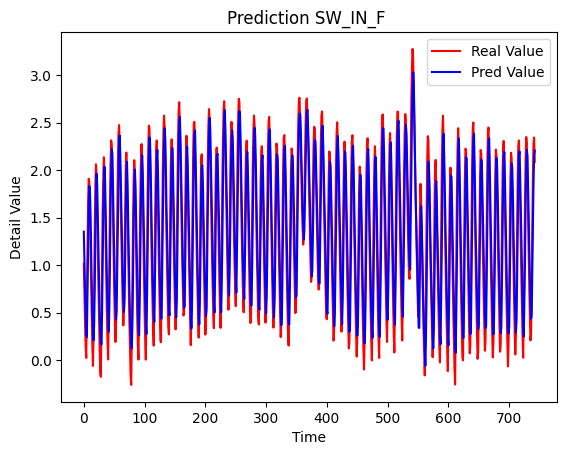

MSE: 0.13738792174018472
MAE: 0.3398870256311319
R²: 0.7737738973681219
RMSE: 0.3706587672512074
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:153: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 3ms/step - loss: 0.0614 - val_loss: 0.0120
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 8/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 11/4

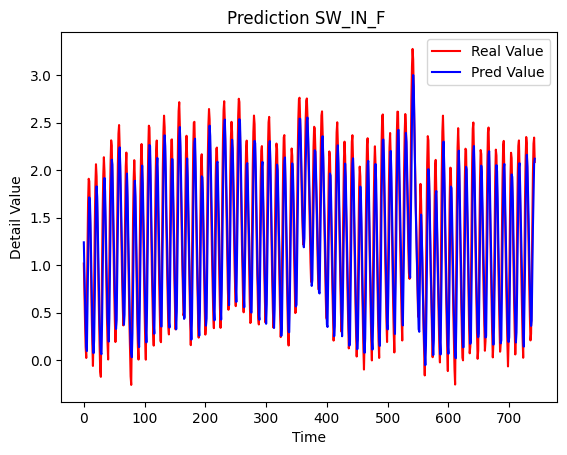

MSE: 0.14764535242161486
MAE: 0.329682034828922
R²: 0.7568837767761174
RMSE: 0.38424647353178776
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:166: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 5ms/step - loss: 0.0401 - val_loss: 0.0105
Epoch 2/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 3/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 4/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 5/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 6/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 7/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 8/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 9/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 10/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 11/4

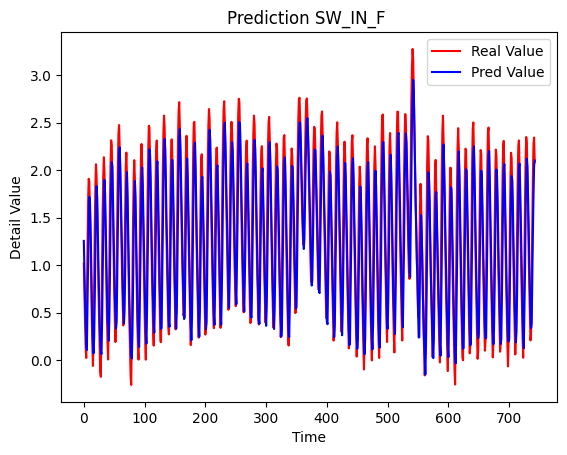

MSE: 0.1512174676665303
MAE: 0.3285563701969417
R²: 0.7510018498951114
RMSE: 0.38886690225131054
Burlington Station.csv
-------------------------
For HONOLULU Station.cs
(5852, 6)
(744, 6)
trainX.Shape:---- (5851, 1, 6)
trainY.shape:---- (5851,)
testX.shape:---- (743, 1, 6)
testY.shape:---- (743,)
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:139: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 1s 3ms/step - loss: 0.0341 - val_loss: 0.0093
Epoch 2/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 8/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 11/4

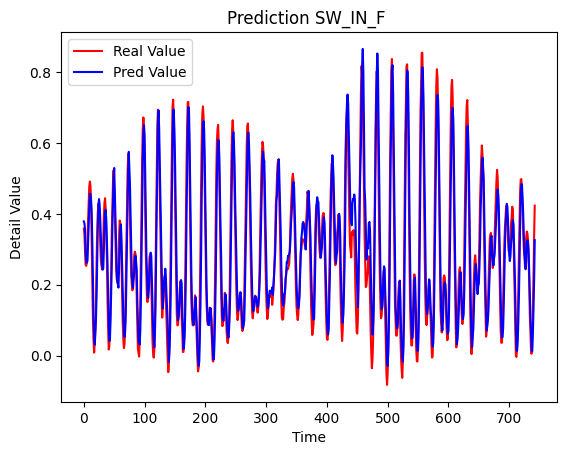

MSE: 0.005533288979065015
MAE: 0.06046998853886733
R²: 0.8640817700408844
RMSE: 0.0743860805464639
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:153: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 3ms/step - loss: 0.0426 - val_loss: 0.0070
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 8/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 11/4

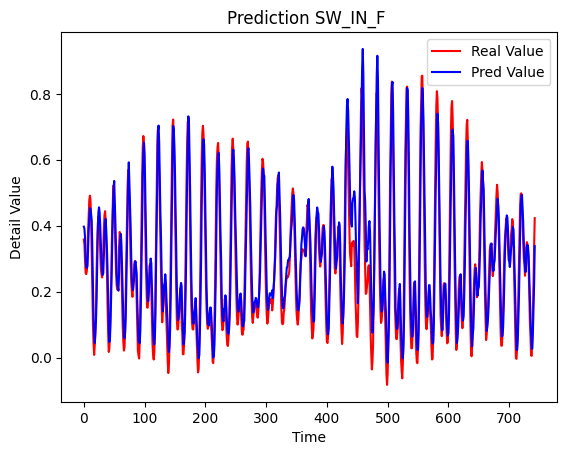

MSE: 0.006135929739630792
MAE: 0.06333988820896323
R²: 0.8492786636448117
RMSE: 0.07833217563447853
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:166: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0248 - val_loss: 0.0054
Epoch 2/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 3/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 4/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 5/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 6/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 7/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 8/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 9/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 10/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 11/4

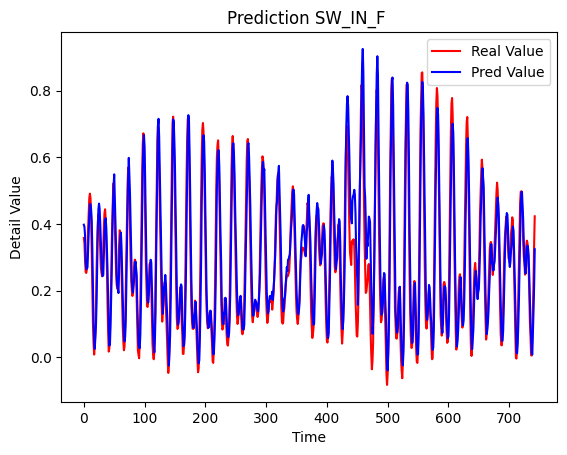

MSE: 0.006184354585113549
MAE: 0.0626259438487053
R²: 0.8480891686972386
RMSE: 0.07864066750170391
HONOLULU Station.csv
-------------------------
For KAHUKUI Station.cs
(5845, 6)
(744, 6)
trainX.Shape:---- (5844, 1, 6)
trainY.shape:---- (5844,)
testX.shape:---- (743, 1, 6)
testY.shape:---- (743,)
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:139: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 1s 2ms/step - loss: 0.0414 - val_loss: 0.0119
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 8/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 11/4

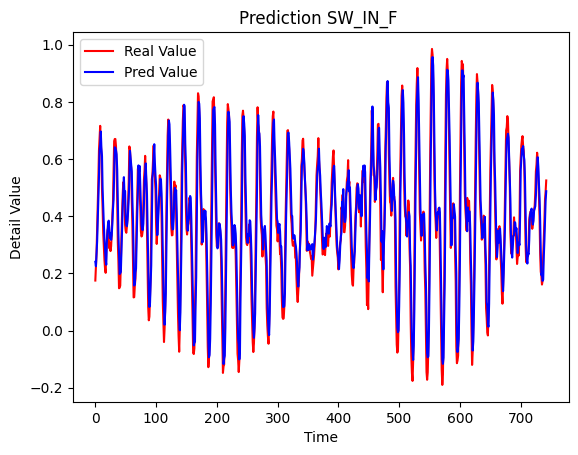

MSE: 0.0074628551704759155
MAE: 0.06899539941005173
R²: 0.8606615536006725
RMSE: 0.08638781841484316
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:153: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0507 - val_loss: 0.0085
Epoch 2/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 3/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 6/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 7/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 8/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 9/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 11/4

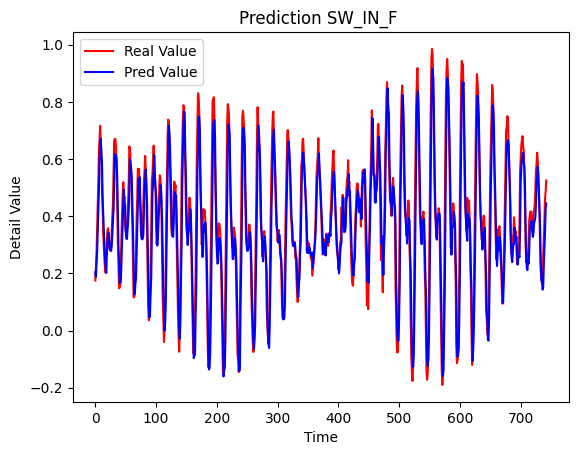

MSE: 0.00838536003391383
MAE: 0.07120693401618704
R²: 0.8434375298817363
RMSE: 0.0915716115065899
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:166: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 6ms/step - loss: 0.0306 - val_loss: 0.0067
Epoch 2/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 4/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 5/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 6/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 7/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 8/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 9/40
183/183 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 10/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 11/4

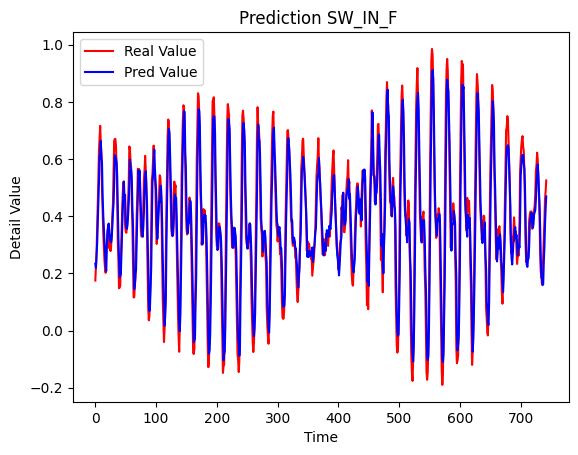

MSE: 0.00734848372987187
MAE: 0.06832232704908808
R²: 0.8627969747608294
RMSE: 0.08572329747432648
KAHUKUI Station.csv
-------------------------
For LaJolla Station.cs
(5854, 6)
(744, 6)
trainX.Shape:---- (5853, 1, 6)
trainY.shape:---- (5853,)
testX.shape:---- (743, 1, 6)
testY.shape:---- (743,)
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:139: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 1s 4ms/step - loss: 0.0491 - val_loss: 0.0111
Epoch 2/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 3/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 4/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 8/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 9/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 11/4

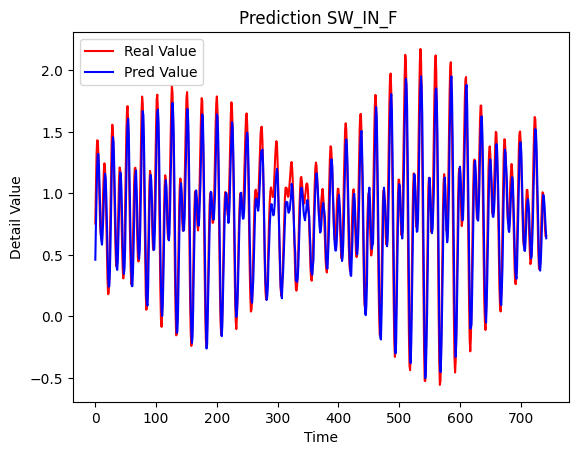

MSE: 0.041799753722495024
MAE: 0.1711163760988195
R²: 0.844574777990246
RMSE: 0.2044498807103957
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:153: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0608 - val_loss: 0.0092
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 3/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 8/40
183/183 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 9/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/40
183/183 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 11/4

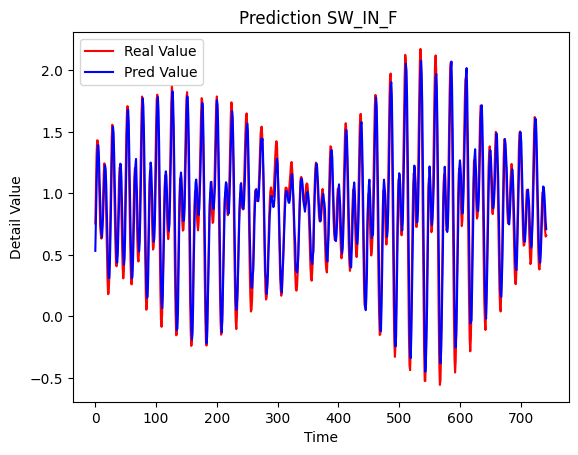

MSE: 0.040028659621509914
MAE: 0.1651018821428634
R²: 0.8511602879354311
RMSE: 0.20007163622440316
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:166: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0357 - val_loss: 0.0068
Epoch 2/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 4/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 9/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11/4

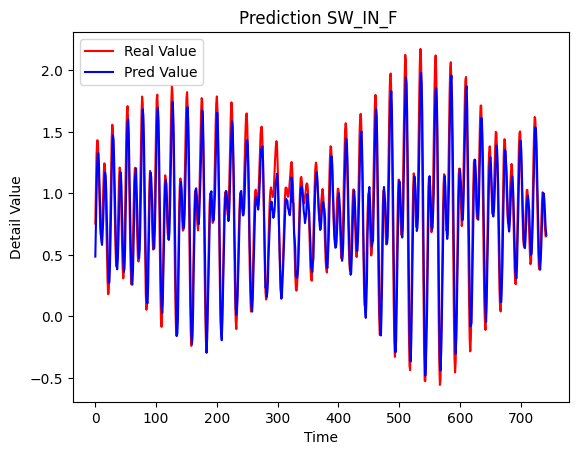

MSE: 0.040467495370148765
MAE: 0.1679329183899859
R²: 0.8495285523967285
RMSE: 0.20116534336249067
LaJolla Station.csv
-------------------------
For Nawiliwili Station.cs
(5854, 6)
(744, 6)
trainX.Shape:---- (5853, 1, 6)
trainY.shape:---- (5853,)
testX.shape:---- (743, 1, 6)
testY.shape:---- (743,)
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:139: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0286 - val_loss: 0.0099
Epoch 2/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 3/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 8/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 9/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 11/4

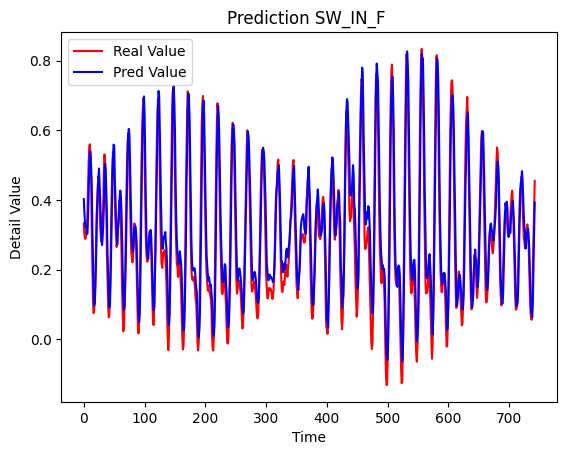

MSE: 0.005067311093431576
MAE: 0.05976029194754074
R²: 0.8692590600910419
RMSE: 0.07118504824351513
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:153: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(Stack_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 4ms/step - loss: 0.0374 - val_loss: 0.0079
Epoch 2/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 4/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 8/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/40
183/183 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 11/4

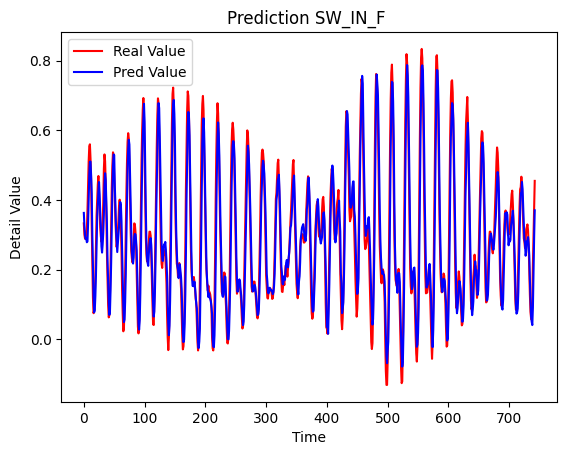

MSE: 0.0046623498240883155
MAE: 0.05483256488236362
R²: 0.8797074055753545
RMSE: 0.06828140174372752
Epoch 1/40


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_36348\3688607024.py:166: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


183/183 [==============================] - 2s 5ms/step - loss: 0.0213 - val_loss: 0.0042
Epoch 2/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/40
183/183 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 9/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/40
183/183 [==============================] - 1s 4ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 11/4

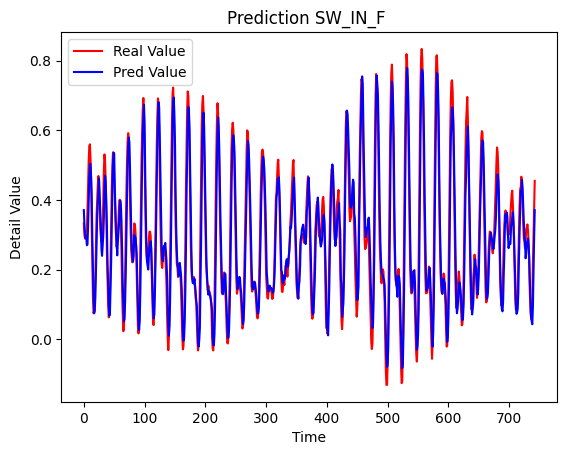

MSE: 0.004579114869405584
MAE: 0.05439629246941034
R²: 0.8818549382623856
RMSE: 0.06766915744566046
Nawiliwili Station.csv
-------------------------


In [8]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path,'*.csv'))
#
# for file in csv_files:
#  LSTM_ALL(os.path.basename(file))
#  print(os.path.basename(file))
#  print("-------------------------")
import os
import glob
## 0-3 , 3-5,5-7,7-9,9-12
csv_path = '../../Data/NOAA/All Station'
csv_files = glob.glob(os.path.join(csv_path, '*.csv'))

start_index = 0  # 起始索引，即第1个文件
end_index = 5 # 结束索引，即第3个文件

for index, file in enumerate(csv_files[start_index:end_index]):
    LSTM_ALL(os.path.basename(file))
    print(os.path.basename(file))
    print("-------------------------")

In [69]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path, '*.csv'))
#
# start_index = 10  # 起始索引，即第4个文件
# end_index = 12  # 结束索引，即第6个文件（不包括第7个文件）
#
# for index, file in enumerate(csv_files[start_index:end_index]):
#     # LSTM_ALL(os.path.basename(file))
#     print(os.path.basename(file))
#     print("-------------------------")

xlsx_file = 'CEEMDAN_Data/'
xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))
for path in xlsx_path:
    print(path)

NameError: name 'glob' is not defined

In [68]:
df = pd.read_excel('CEEMDAN_Data/results_Burlington Station_AT.xlsx')
df

IMF1      IMF2      IMF3      IMF4      IMF5      IMF6      IMF7  \
0    -0.033828  0.023025 -0.229006 -0.187968  0.057405  0.335733 -1.976478   
1    -0.120510  0.021154 -0.404673 -0.158613  0.095930  0.369184 -2.011840   
2     0.108706 -0.084826 -0.174864 -0.123642  0.128295  0.382339 -2.043766   
3    -0.337743 -0.013265 -0.103795 -0.009508  0.155401  0.374779 -2.072145   
4    -0.316090  0.084231  0.246660  0.143378  0.183242  0.350298 -2.096609   
...        ...       ...       ...       ...       ...       ...       ...   
8772  0.297783  0.085342  0.224087  0.243745 -0.015514  1.415649  0.655405   
8773  1.060568  0.102266  0.113059 -0.243996 -0.073754  1.389236  0.646374   
8774 -0.228767  0.010369 -0.216563 -0.513965 -0.144210  1.344004  0.632332   
8775 -1.133619 -0.167837 -0.653397 -0.566877 -0.199445  1.282060  0.613918   
8776 -1.206771 -0.440272 -0.620006 -0.553882 -0.206617  1.204429  0.591629   

          IMF8      IMF9     IMF10     IMF11     IMF12     IMF13  Residual  
0    -0.305790 -0.410745 -0.641850  0.619778 -0.602289  0.923267  4.228745  
1    -0.304776 -0.412316 -0.643379  0.620278 -0.602513  0.923337  4.228737  
2    -0.303812 -0.413690 -0.644909  0.620772 -0.602737  0.923406  4.228728  
3    -0.302913 -0.414867 -0.646438  0.621259 -0.602960  0.923476  4.228720  
4    -0.302104 -0.415852 -0.647968  0.621740 -0.603184  0.923546  4.228711  
...        ...       ...       ...       ...       ...       ...       ...  
8772 -1.248864 -0.634797 -0.463312  0.327637  0.449764  0.927064  3.536011  
8773 -1.234875 -0.633458 -0.463655  0.325759  0.449435  0.927030  3.536010  
8774 -1.223218 -0.632048 -0.463913  0.323874  0.449104  0.926994  3.536008  
8775 -1.213868 -0.630564 -0.464087  0.321980  0.448772  0.926958  3.536006  
8776 -1.206770 -0.629004 -0.464176  0.320078  0.448438  0.926921  3.536005  

[8777 rows x 14 columns]

In [42]:
df = pd.read_csv('../../Data/NOAA/All Station/Burlington Station.csv')
df

Date Time (GMT)  Wind Speed (m/s)  Wind Dir (deg)  Wind Gust (m/s)  \
0     2022/1/1       0:00               0.9             192              1.8   
1     2022/1/1       1:00               1.0             223              1.6   
2     2022/1/1       2:00               1.4             169              2.0   
3     2022/1/1       3:00               1.3             185              1.8   
4     2022/1/1       4:00               1.7             186              2.4   
...        ...        ...               ...             ...              ...   
8772  2023/1/1      19:00               4.1             269              5.8   
8773  2023/1/1      20:00               5.5             262              5.9   
8774  2023/1/1      21:00               2.9             295              3.8   
8775  2023/1/1      22:00               1.9             249              2.1   
8776  2023/1/1      23:00               1.0             278              1.7   

      Air Temp (°C)  Baro (mb)  Water Level(m)  
0              10.3     1014.2           2.411  
1              10.3     1014.3           2.436  
2              10.2     1013.4           2.104  
3               9.7     1013.2           1.677  
4               9.8     1013.0           1.255  
...             ...        ...             ...  
8772           11.0     1014.3           0.644  
8773           10.3     1014.4           1.150  
8774           12.2     1014.6           1.749  
8775           10.5     1014.8           2.114  
8776            7.5     1016.0           2.251  

[8777 rows x 8 columns]

In [64]:
df = pd.read_csv('../../Data/NOAA/All Station/Burlington Station.csv')

In [65]:
df_colum = df[['Wind Speed (m/s)','Wind Dir (deg)','Wind Gust (m/s)','Air Temp (°C)','Baro (mb)','Water Level(m)']]

In [66]:
# from PyEMD import CEEMDAN
# def get_CEEMD_residue(data,factor_name):
#     """
#     Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
#     The difference is that the information about the noise is shared among all workers
#
#     :returns:
#     IMFs : numpy array
#         All the Intrinsic Mode Functions that make up the original stock price
#     residue : numpy array
#         The residue from the recently analyzed stock price
#     """
#
#     data_np = data.to_numpy().reshape(-1)
#     print("Data shape:", data_np.shape)
#     print("Data array:", data_np)
#     ceemd = CEEMDAN()
#     ceemd.extrema_detection="parabol"
#     ceemd.ceemdan(data_np)
#     IMFs, residue = ceemd.get_imfs_and_residue()
#     print(residue[0:10])
#     nIMFs = IMFs.shape[0]
#
#     # # 创建 DataFrame 存储 IMFs 和 residue 数据
#     # imf_df = pd.DataFrame(IMFs.T, columns=[f"IMF{i+1}" for i in range(nIMFs)])
#     # residue_df = pd.DataFrame({"Residue": residue})
#     #
#     # # 将 DataFrame 保存为 CSV 文件
#     # imf_df.to_csv("IMFs.csv", index=False)
#     # residue_df.to_csv("Residue.csv", index=False)
#
#     print('nIMFs.Shape',nIMFs)
#     plt.figure(figsize=(18,12))
#     plt.subplot(nIMFs + 2, 1, 1)
#
#     plt.plot(data, 'r')
#     plt.ylabel("S&P500")
#
#     plt.subplot(nIMFs + 2, 1, nIMFs + 2)
#     plt.plot(data.index, residue)
#     plt.ylabel("Residue")
#
#     for n in range(nIMFs):
#         plt.subplot(nIMFs + 2, 1, n + 2)
#         plt.plot(data.index, IMFs[n], 'g')
#         plt.ylabel("eIMF %i" % (n + 1))
#         plt.locator_params(axis='y', nbins=4)
#
#     plt.tight_layout()
#     plt.show()
#     # 创建 DataFrame 存储 IMFs 和 residue 数据
#     column_names_imfs = [f"IMF{i+1}" for i in range(nIMFs)]
#     imf_df = pd.DataFrame(IMFs.T, columns=column_names_imfs)
#     residue_df = pd.DataFrame({"Residue": residue})
#
#     # 合并 IMFs 和 residue DataFrame
#     combined_df = pd.concat([imf_df, residue_df], axis=1)
#
#     # 将 DataFrame 保存为 CSV 文件
#     combined_df.to_csv(factor_name+"_IMFs_and_Residue.csv", index=False)
#     return IMFs, residue, nIMFs
#
# ## 重构IMFs信号
# def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
#     """
#     This function aims to reconstruct the Time Series using the IMFs
#
#     :param IMFs: The IMFs returned from using any of the decomposition functions above
#     :param residue: The residue returned from using any of the decomposition functions above
#     :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
#     :return: None
#     """
#
#     sum_IMFs = sum(IMFs[-num_IMFs:])
#     sum_IMFs += residue
#
#     plt.figure(figsize=(12, 10))
#     plt.plot(data.index, data, label="Stock Price")
#     plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
#     plt.legend(loc="upper left")
#     plt.show()

## 循环分解每个变量

----------- Wind Speed (m/s) -------------
Data shape: (8777,)
Data array: [0.9 1.  1.4 ... 2.9 1.9 1. ]
[ 1.11022302e-16  4.44089210e-16 -2.22044605e-16  0.00000000e+00
  0.00000000e+00 -4.44089210e-16 -2.22044605e-16  2.22044605e-16
 -6.66133815e-16  2.22044605e-16]
nIMFs.Shape 11


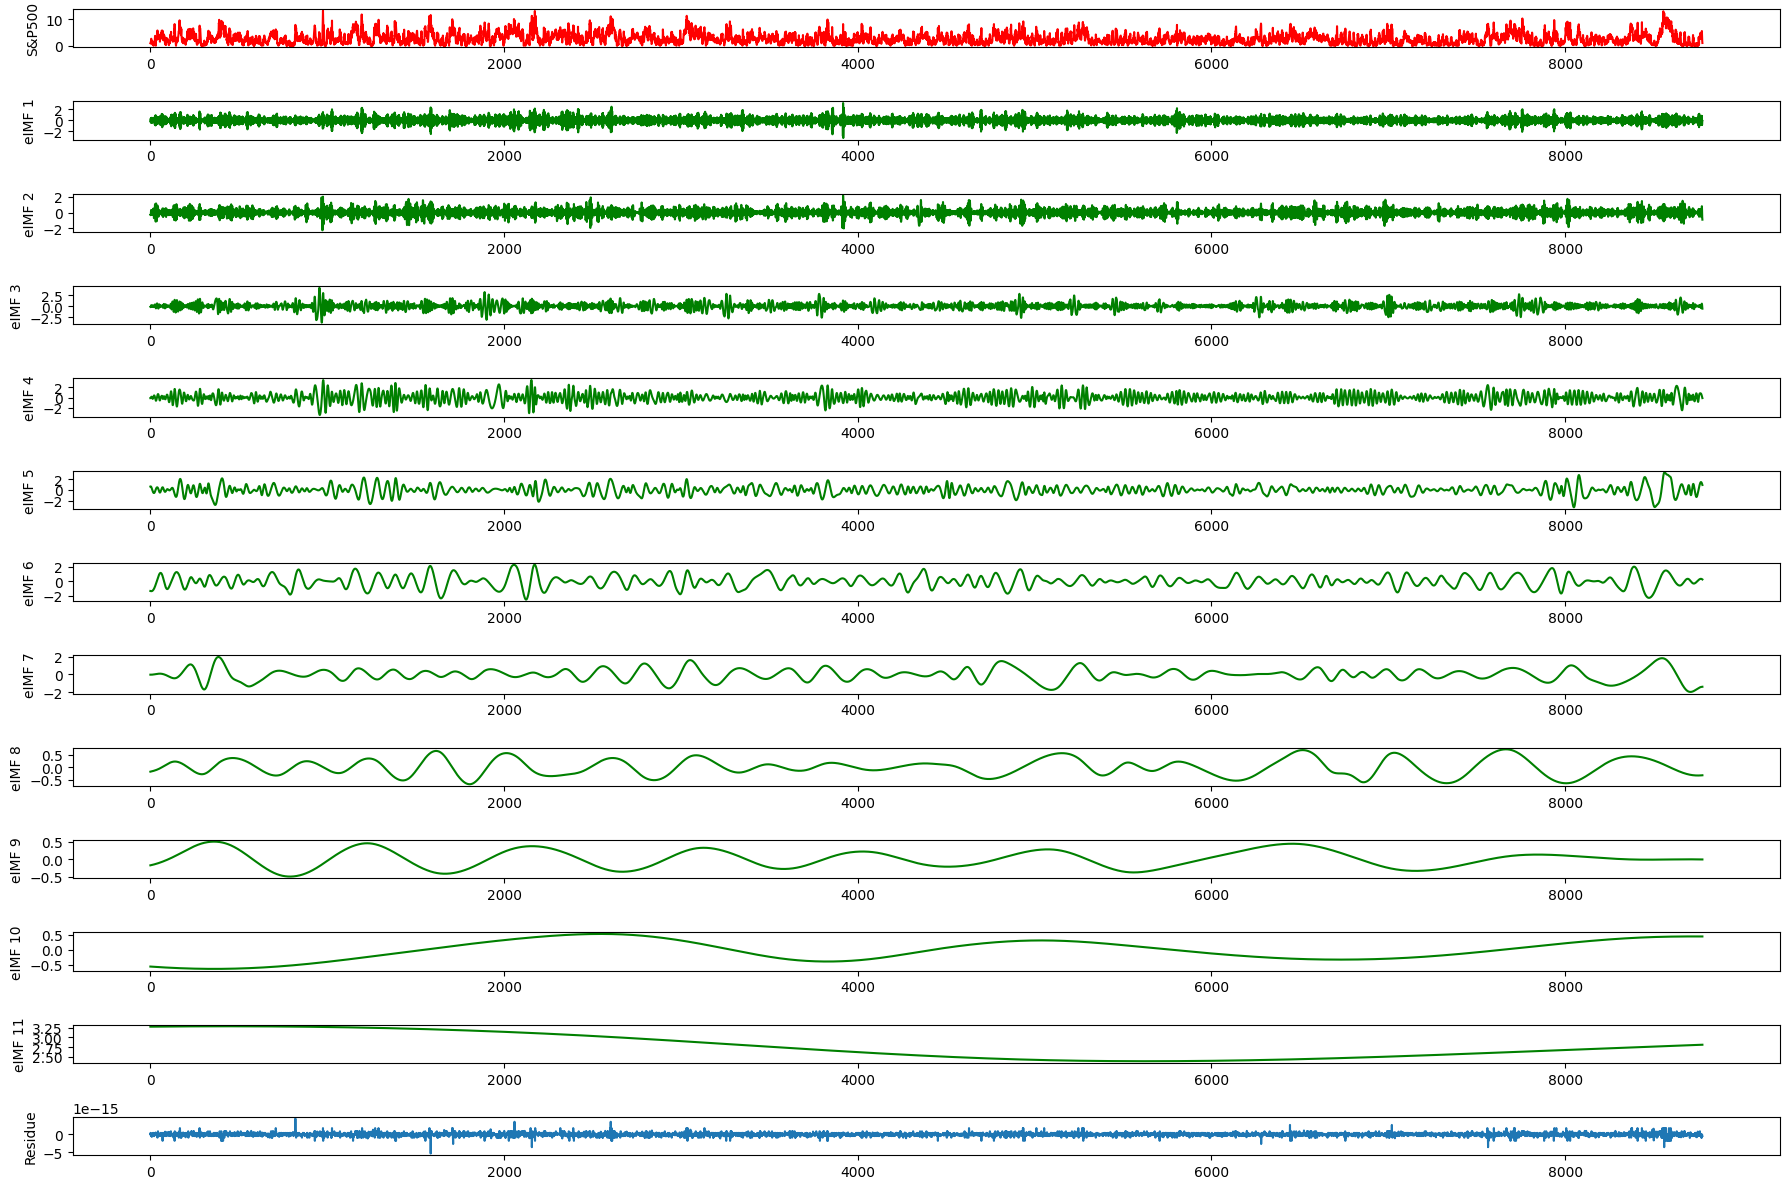

----------- Wind Dir (deg) -------------
Data shape: (8777,)
Data array: [192 223 169 ... 295 249 278]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.84217094e-14 0.00000000e+00
 0.00000000e+00 2.84217094e-14]
nIMFs.Shape 13


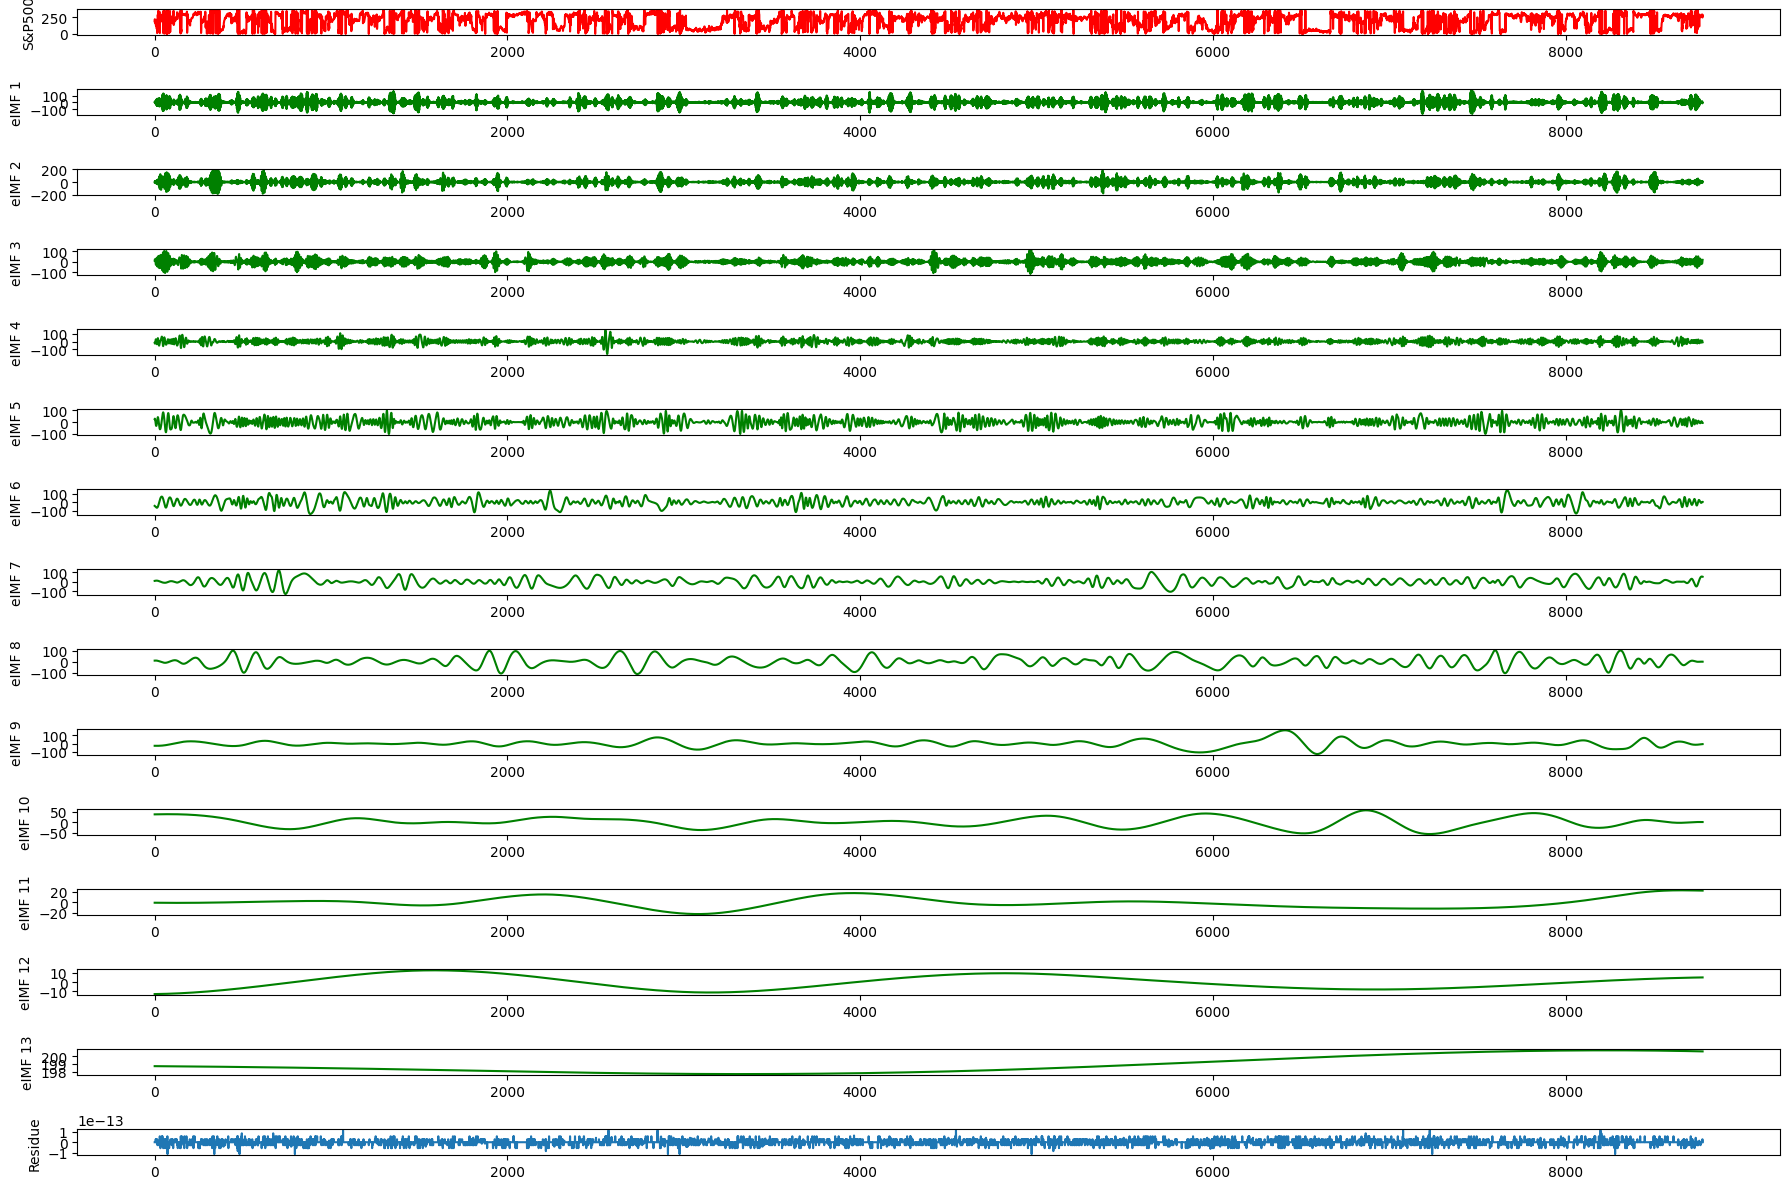

----------- Wind Gust (m/s) -------------
Data shape: (8777,)
Data array: [1.8 1.6 2.  ... 3.8 2.1 1.7]
[ 0.0000000e+00  4.4408921e-16  4.4408921e-16 -8.8817842e-16
 -4.4408921e-16  0.0000000e+00  0.0000000e+00  4.4408921e-16
  0.0000000e+00  4.4408921e-16]
nIMFs.Shape 11


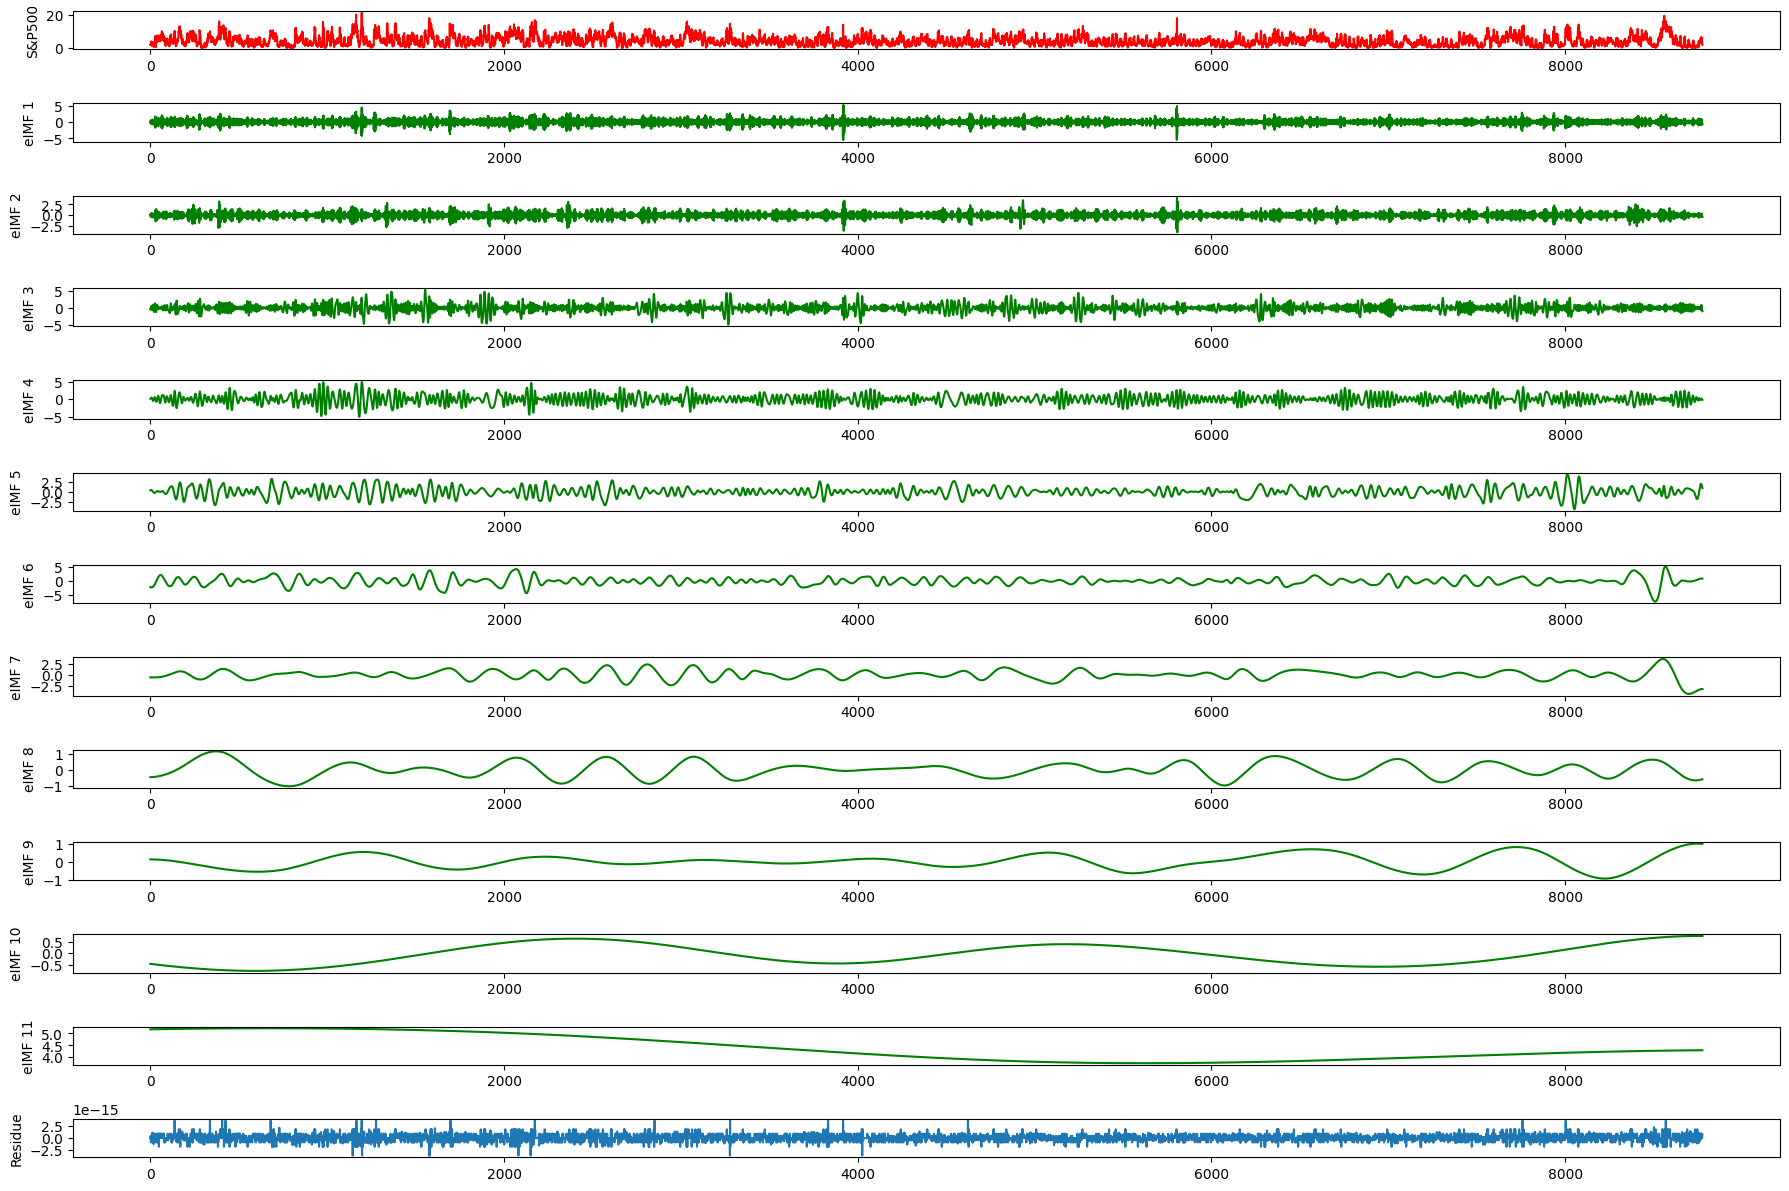

----------- Air Temp (°C) -------------
Data shape: (8777,)
Data array: [10.3 10.3 10.2 ... 12.2 10.5  7.5]
[ 1.77635684e-15  0.00000000e+00  1.77635684e-15  0.00000000e+00
 -1.77635684e-15  0.00000000e+00 -1.77635684e-15 -1.77635684e-15
  1.77635684e-15 -3.55271368e-15]
nIMFs.Shape 10


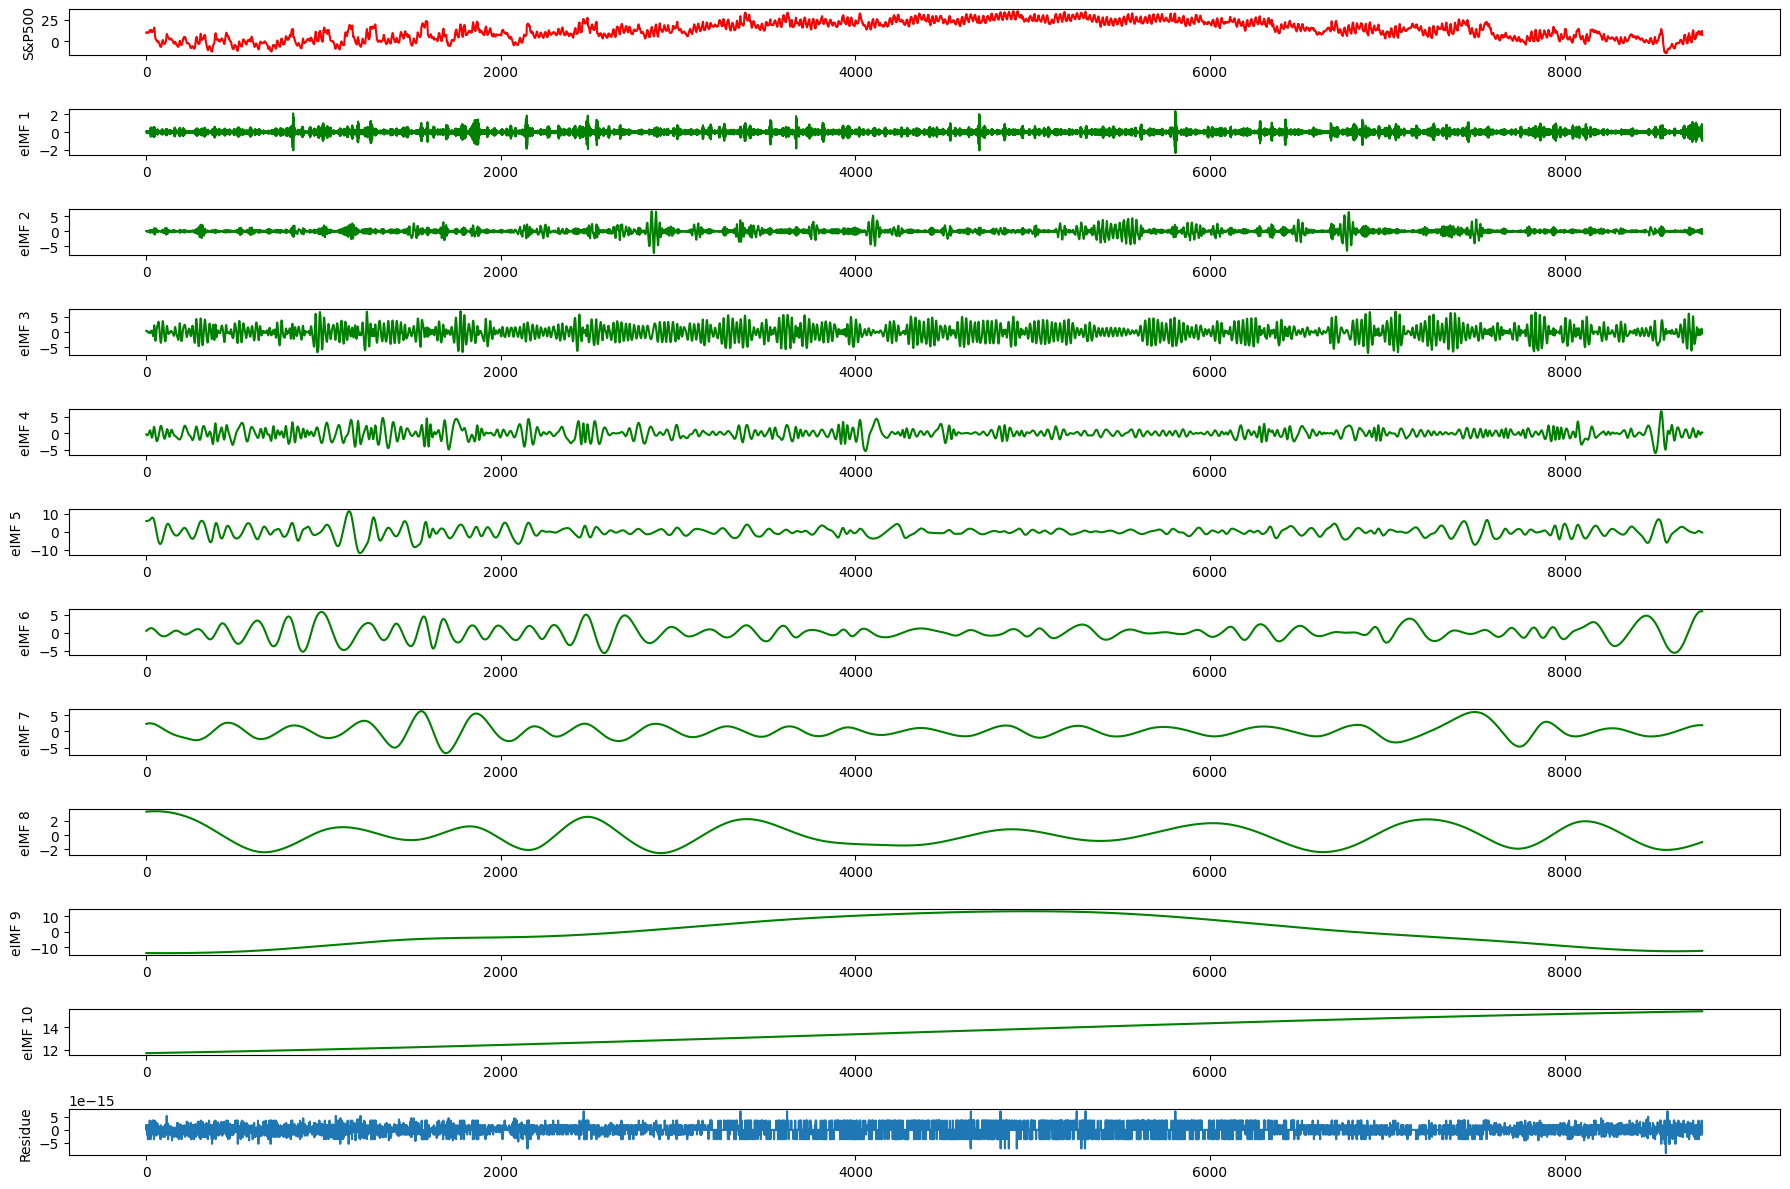

----------- Baro (mb) -------------
Data shape: (8777,)
Data array: [1014.2 1014.3 1013.4 ... 1014.6 1014.8 1016. ]
[ 0.00000000e+00  1.13686838e-13  1.13686838e-13  1.13686838e-13
  1.13686838e-13 -1.13686838e-13  0.00000000e+00  0.00000000e+00
 -1.13686838e-13  1.13686838e-13]
nIMFs.Shape 10


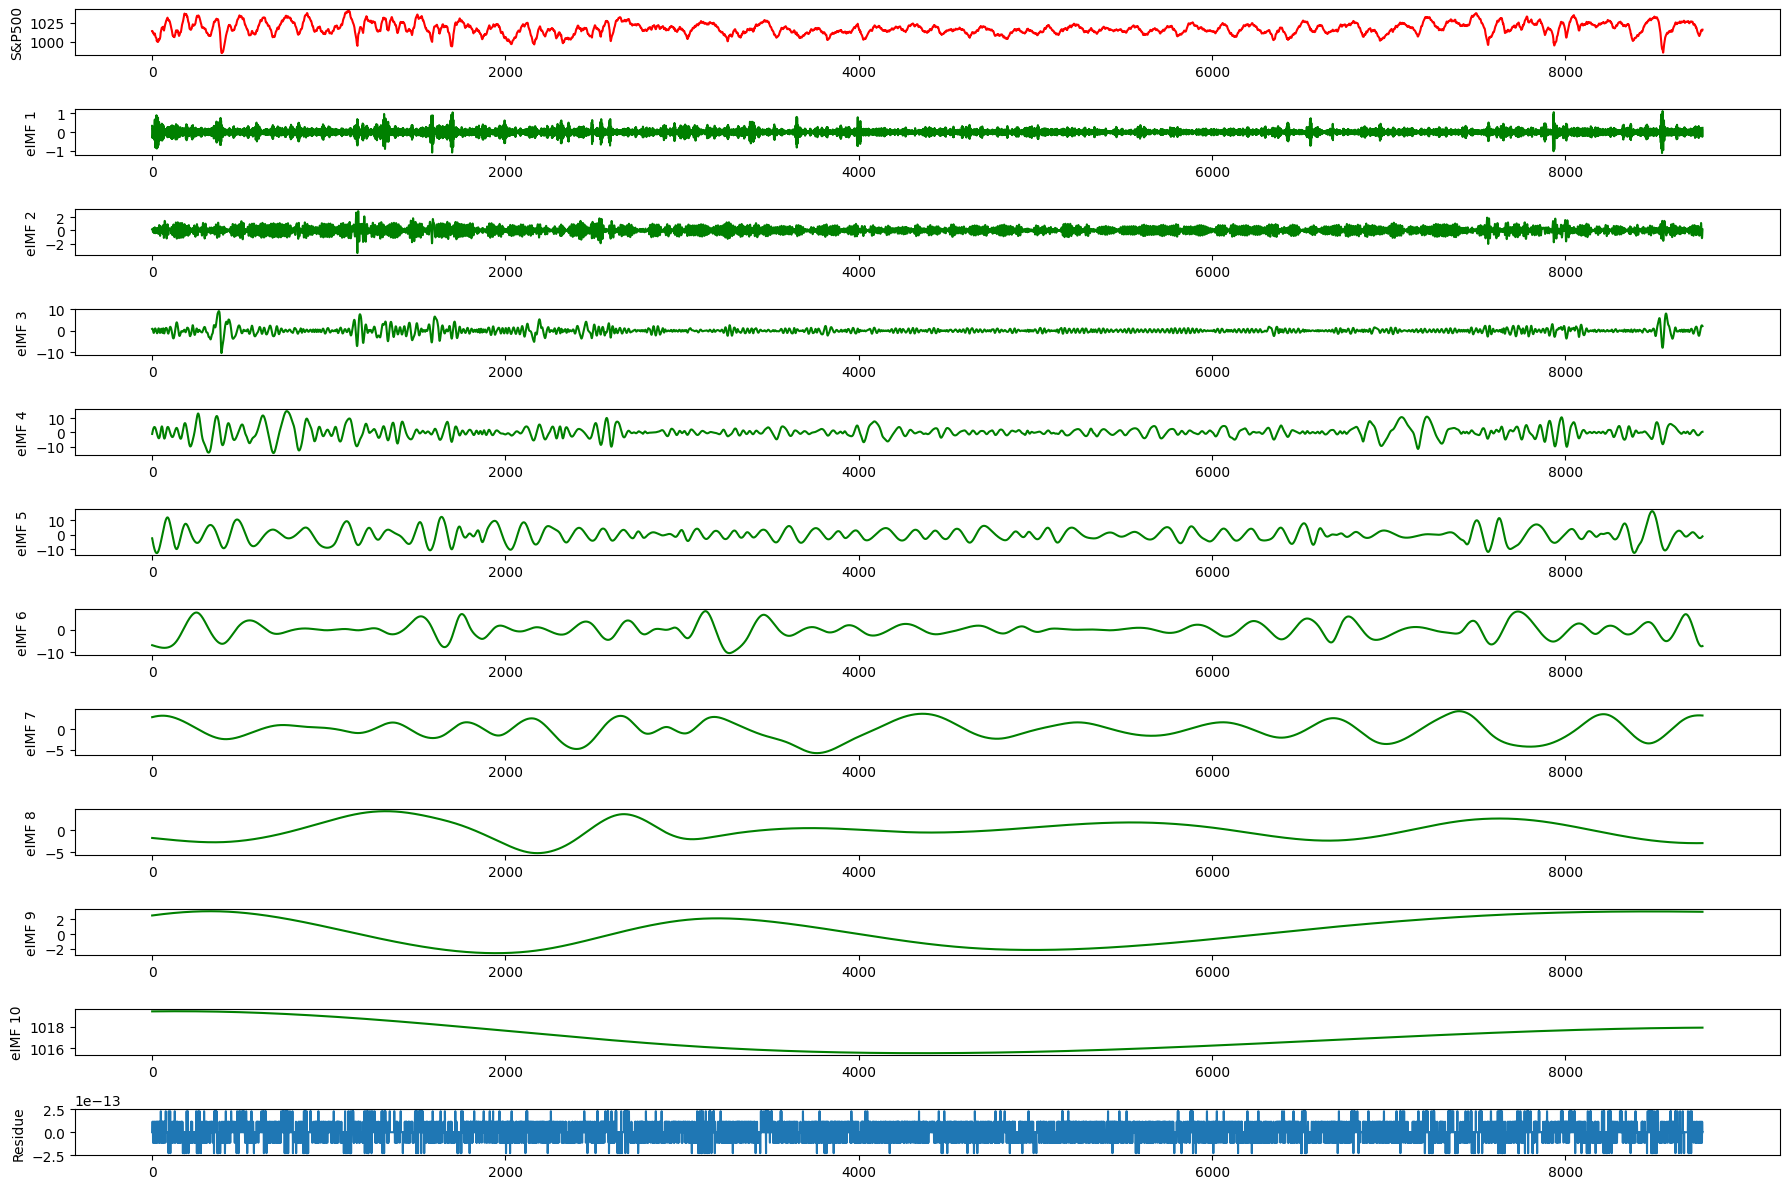

----------- Water Level(m) -------------
Data shape: (8777,)
Data array: [2.411 2.436 2.104 ... 1.749 2.114 2.251]
[-4.44089210e-16  0.00000000e+00  0.00000000e+00  2.22044605e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.00000000e+00]
nIMFs.Shape 10


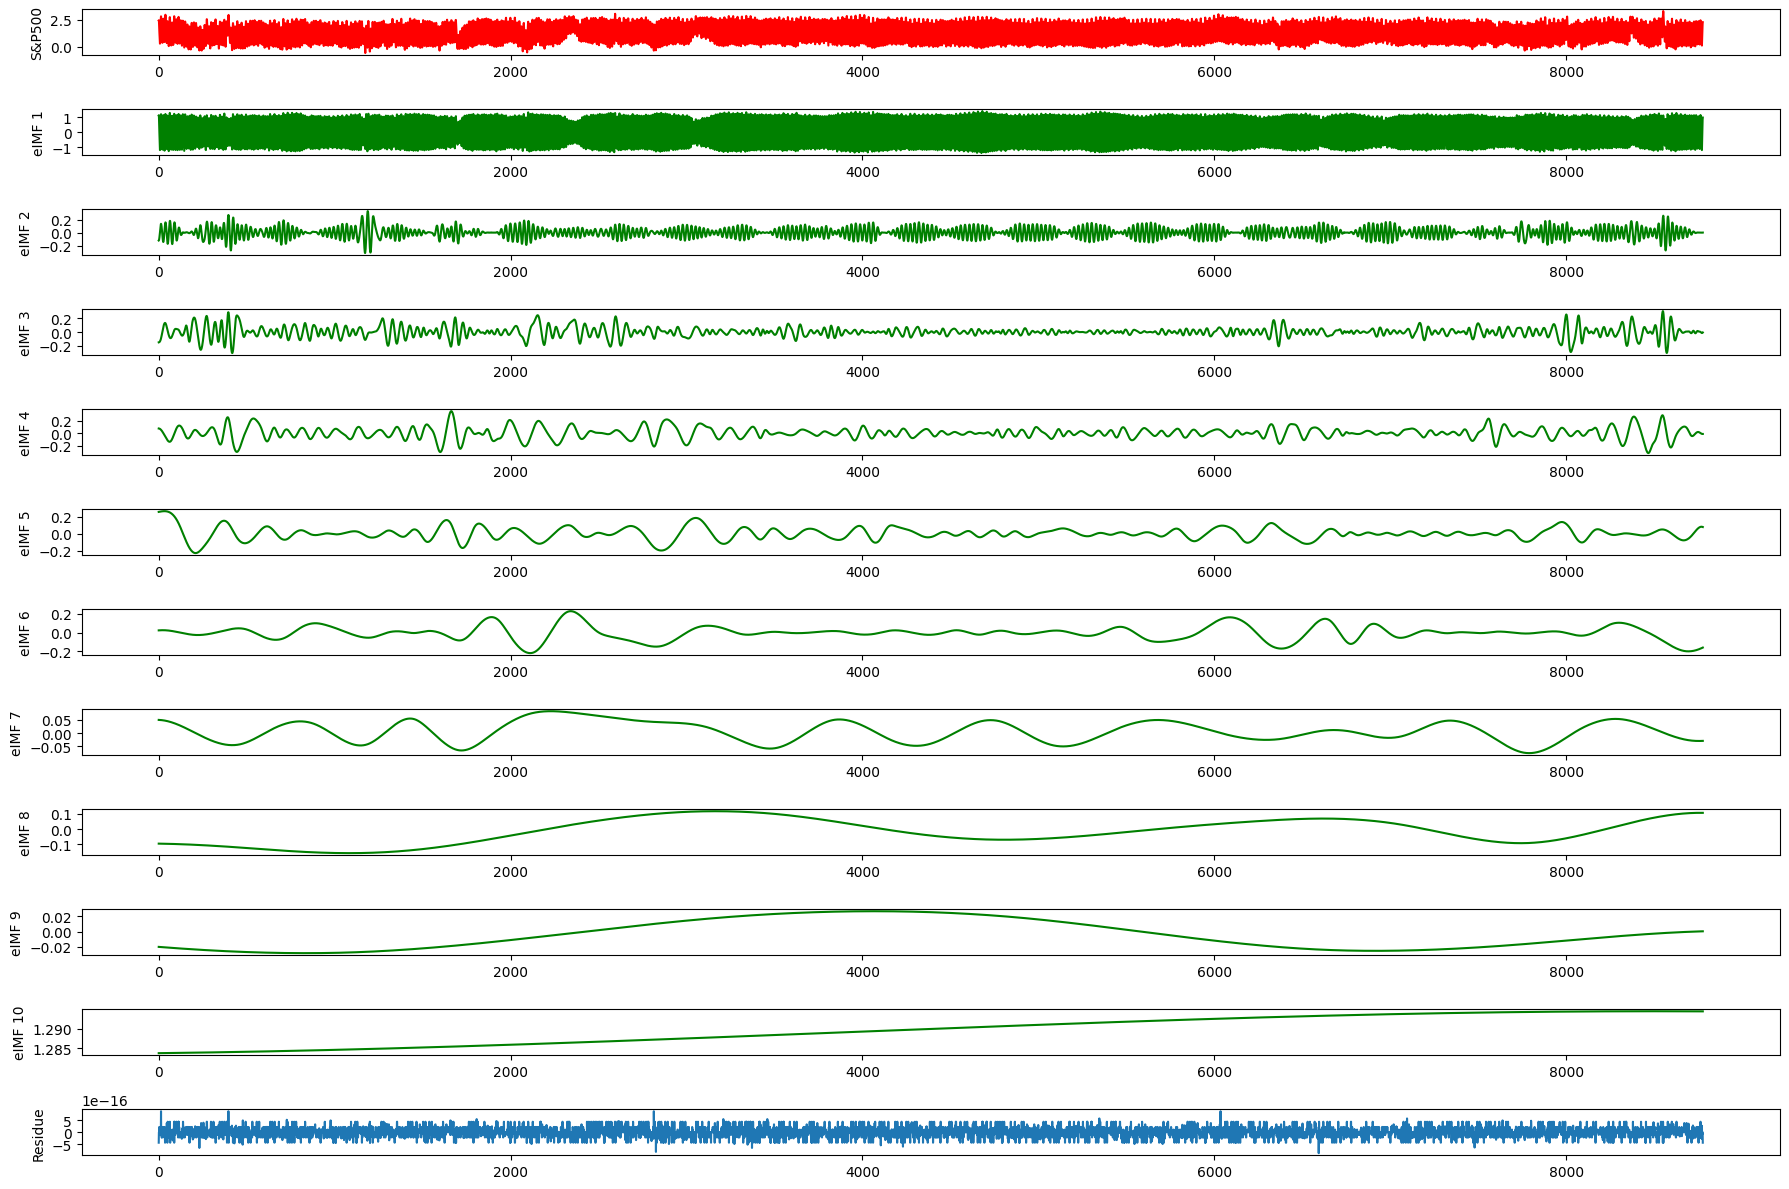

In [67]:
for df_name in df_colum:
    df_imf = df[[df_name]]
    factor_name = df_name.split('(')[0]
    print('-----------',df_name,'-------------')
    get_CEEMD_residue(df_imf,factor_name)

In [38]:
from PyEMD import CEEMDAN
def get_CEEMD_residue(data):
    """
    Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
    The difference is that the information about the noise is shared among all workers

    :returns:
    IMFs : numpy array
        All the Intrinsic Mode Functions that make up the original stock price
    residue : numpy array
        The residue from the recently analyzed stock price
    """

    data_np = data.to_numpy().reshape(-1)
    print("Data shape:", data_np.shape)
    print("Data array:", data_np)
    ceemd = CEEMDAN()
    ceemd.extrema_detection="parabol"
    ceemd.ceemdan(data_np)
    IMFs, residue = ceemd.get_imfs_and_residue()
    print(residue[0:10])
    nIMFs = IMFs.shape[0]

    # # 创建 DataFrame 存储 IMFs 和 residue 数据
    # imf_df = pd.DataFrame(IMFs.T, columns=[f"IMF{i+1}" for i in range(nIMFs)])
    # residue_df = pd.DataFrame({"Residue": residue})
    #
    # # 将 DataFrame 保存为 CSV 文件
    # imf_df.to_csv("IMFs.csv", index=False)
    # residue_df.to_csv("Residue.csv", index=False)

    print('nIMFs.Shape',nIMFs)
    plt.figure(figsize=(18,12))
    plt.subplot(nIMFs + 2, 1, 1)

    plt.plot(data, 'r')
    plt.ylabel("S&P500")

    plt.subplot(nIMFs + 2, 1, nIMFs + 2)
    plt.plot(data.index, residue)
    plt.ylabel("Residue")

    for n in range(nIMFs):
        plt.subplot(nIMFs + 2, 1, n + 2)
        plt.plot(data.index, IMFs[n], 'g')
        plt.ylabel("eIMF %i" % (n + 1))
        plt.locator_params(axis='y', nbins=4)

    plt.tight_layout()
    plt.show()
    # 创建 DataFrame 存储 IMFs 和 residue 数据
    column_names_imfs = [f"IMF{i+1}" for i in range(nIMFs)]
    imf_df = pd.DataFrame(IMFs.T, columns=column_names_imfs)
    residue_df = pd.DataFrame({"Residue": residue})

    # 合并 IMFs 和 residue DataFrame
    combined_df = pd.concat([imf_df, residue_df], axis=1)

    # 将 DataFrame 保存为 CSV 文件
    combined_df.to_csv("IMFs_and_Residue.csv", index=False)
    return IMFs, residue, nIMFs

## 重构IMFs信号
def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
    """
    This function aims to reconstruct the Time Series using the IMFs

    :param IMFs: The IMFs returned from using any of the decomposition functions above
    :param residue: The residue returned from using any of the decomposition functions above
    :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
    :return: None
    """

    sum_IMFs = sum(IMFs[-num_IMFs:])
    sum_IMFs += residue

    plt.figure(figsize=(12, 10))
    plt.plot(data.index, data, label="Stock Price")
    plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
    plt.legend(loc="upper left")
    plt.show()

Data shape: (8777,)
Data array: [2.411 2.436 2.104 ... 1.749 2.114 2.251]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  1.11022302e-16  1.11022302e-16  0.00000000e+00
  2.22044605e-16  2.22044605e-16]
nIMFs.Shape 9


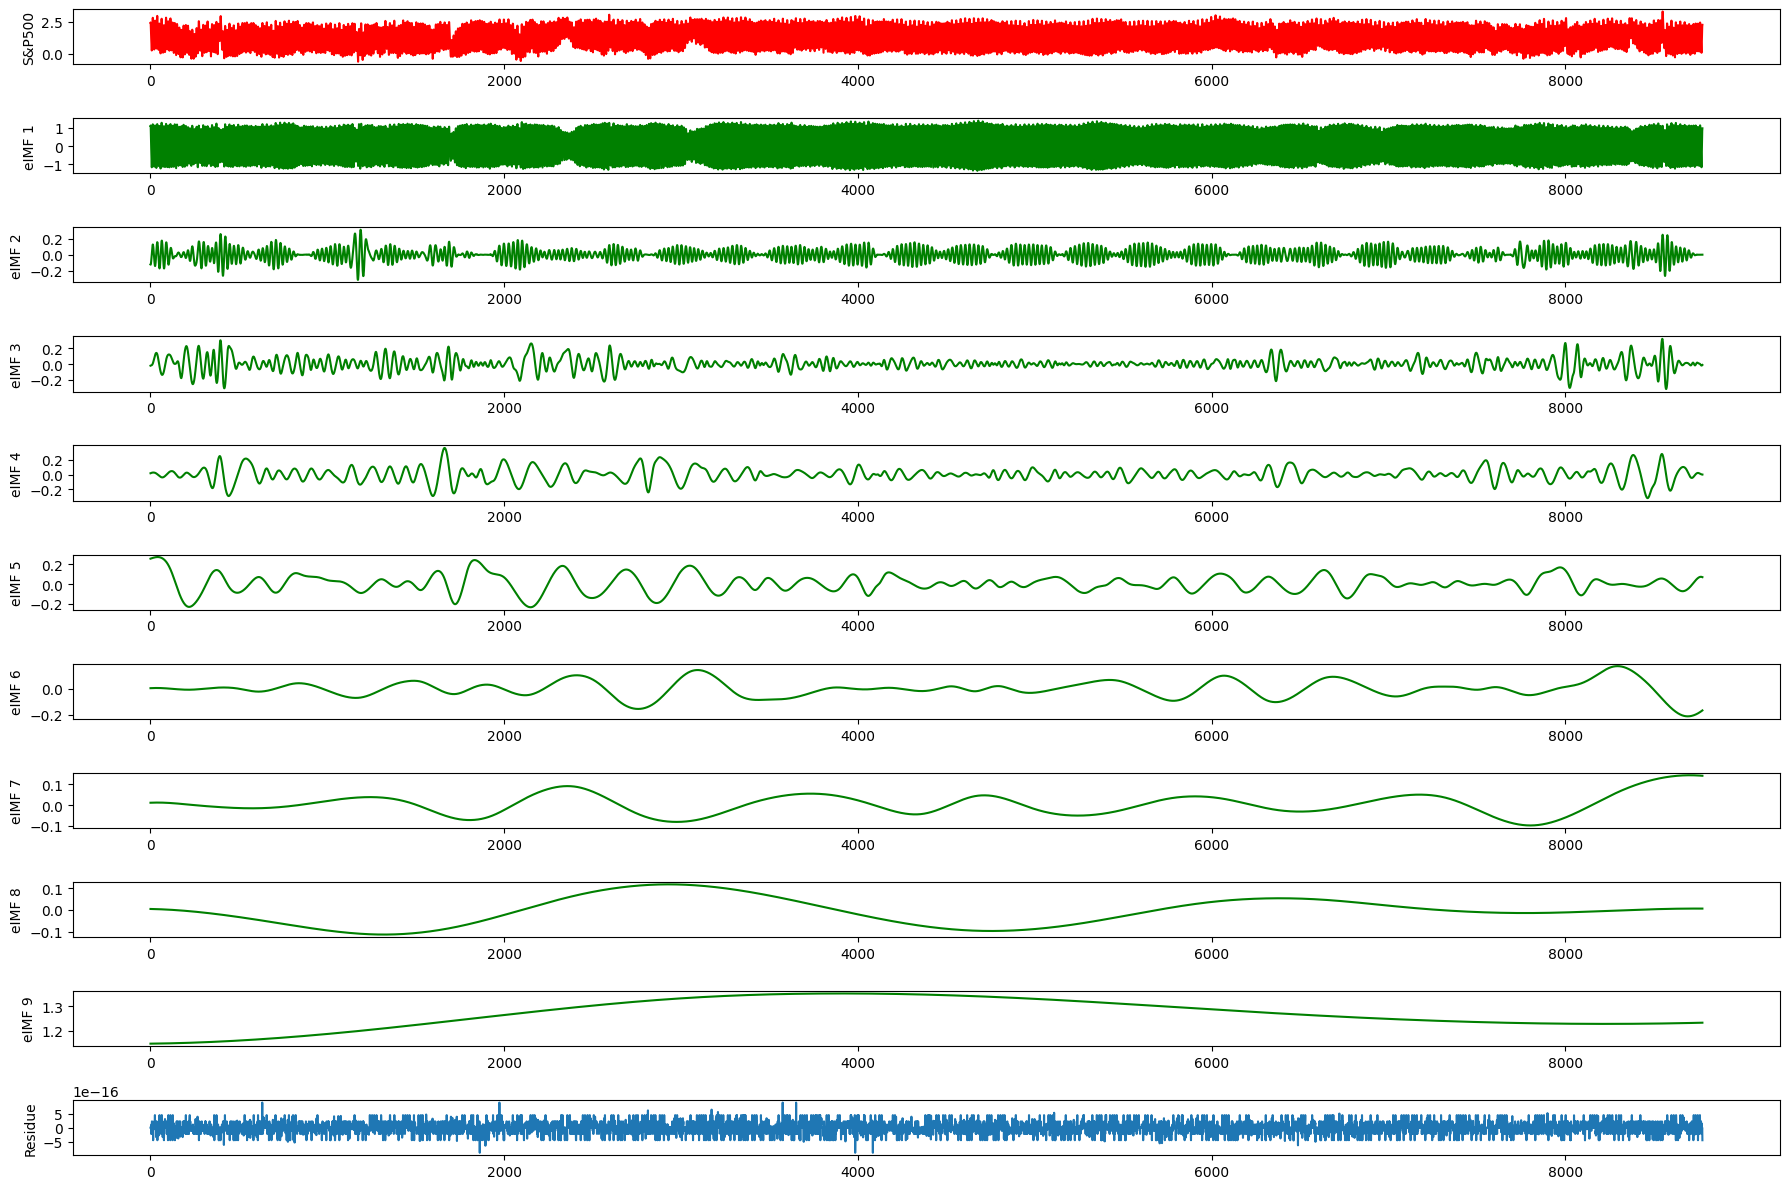

In [39]:
IMFS,residue,n = get_CEEMD_residue(df)

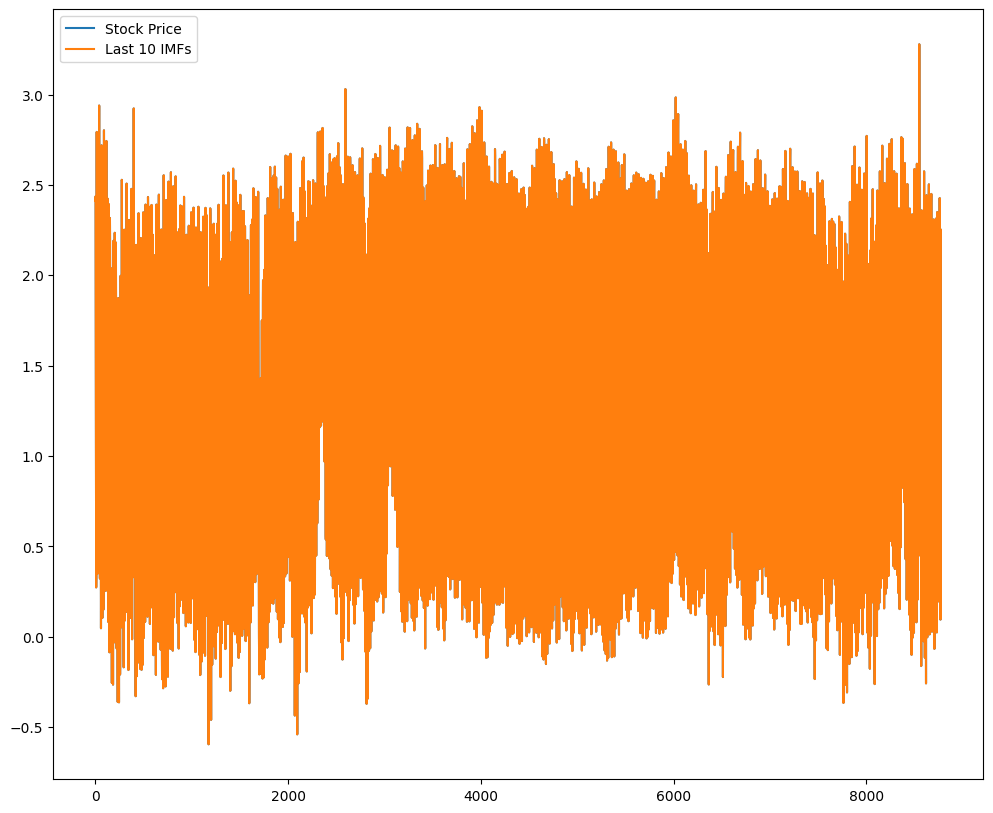

In [31]:
plot_IMFs(IMFS,residue,n,df)

In [25]:
df

Water Level(m)
0              2.411
1              2.436
2              2.104
3              1.677
4              1.255
...              ...
8772           0.644
8773           1.150
8774           1.749
8775           2.114
8776           2.251

[8777 rows x 1 columns]

In [7]:
# df.iloc[-300:,:]

In [8]:
# 数据范围过大，对数据进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [9]:
#数据集划分
test_split = round(len(df) * 0.20)
print(test_split)
def splitData(var, per_test):
    num_test = int(len(var) * per_test)
    train_size = int(len(var) - num_test)
    train_data = var[0:train_size]
    test_data = var[train_size:train_size + num_test]
    return train_data, test_data


1755


In [10]:
df_training, df_testing = splitData(df, 0.2)
print(df_training.shape)
print(df_testing.shape)

(7022, 1)
(1755, 1)


In [11]:
# df_training

In [12]:
"""
划分x和y
dataset:数据集
n_past:过去的样本-拿多少时间序列来作为训练的样本
data_X:多元自变量
data_Y:因变量
将结果转换为array格式用于在LSTM中进行训练
"""


def createXY(dataset, n_past):
    data_X = []
    data_Y = []
    for i in range(n_past, len(dataset)):
        data_X.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        data_Y.append(dataset[i, 0])

    return np.array(data_X), np.array(data_Y)


trainX, trainY = createXY(df_training, 1)
testX, testY = createXY(df_testing, 1)

In [13]:
# trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[2]))
#
# trainX = scaler.inverse_transform(trainX)

In [14]:
# trainY

In [15]:
# original_copies_array = np.repeat(trainY, 14, axis=-1)
# original_copies_array2 = np.reshape(original_copies_array, (len(trainY), 14))
# y_true = scaler.inverse_transform(original_copies_array2)

In [16]:
# y_true[:,1]

In [17]:
print('trainX.Shape:----', trainX.shape)
print('trainY.shape:----', trainY.shape)
print('testX.shape:----', testX.shape)
print('testY.shape:----', testY.shape)
# testY
# original_copies_array = np.repeat(trainY, 14, axis=-1)
# y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(trainY), 14)))[:, 0]

trainX.Shape:---- (7021, 1, 1)
trainY.shape:---- (7021,)
testX.shape:---- (1754, 1, 1)
testY.shape:---- (1754,)


## 读取数据-处理数据

In [18]:
# def trian_data_lstm(data):
# 	df = pd.read_csv('../../Data/PreData/ArtiData/{}'.format(data))
# 	df.head()
# 	df = df.drop('TIMESTAMP_START',axis=1)
#
#     #数据集划分
# 	test_split = round(len(df)*0.20)
# 	print(test_split)
# 	df_training = df[: -test_split]
# 	df_testing = df[-test_split:]
# 	print(df_training.shape)
# 	print(df_testing.shape)
#
# 	# 数据范围过大，对数据进行归一化
# 	scaler = MinMaxScaler(feature_range=(0,1))
# 	df_training_scaled = scaler.fit_transform(df_training)
# 	df_testing_scaled = scaler.transform(df_testing)
#
# 	"""
# 	划分x和y
# 	dataset:数据集
# 	n_past:过去的样本-拿多少时间序列来作为训练的样本
# 	data_X:多元自变量
# 	data_Y:因变量
# 	将结果转换为array格式用于在LSTM中进行训练
# 	"""
# 	def createXY(dataset,n_past):
# 		data_X = []
# 		data_Y = []
# 		for i in range(n_past, len(dataset)):
# 			data_X.append(dataset[i - n_past:i,0:dataset.shape[1]])
# 			data_Y.append(dataset[i,1])
# 		return np.array(data_X),np.array(data_Y)
#
# 	trainX,trainY =createXY(df_training_scaled,1)
# 	testX,testY = createXY(df_testing_scaled,1)
#
# 	print('trainX.Shape:----',trainX.shape)
# 	print('trainY.shape:----',trainY.shape)
# 	print('testX.shape:----',testX.shape)
# 	print('testY.shape:----',testY.shape)

In [19]:
# import os
# import glob
#
# csv_path = '../../Data/PreData/ArtiData'
# csv_files = glob.glob(os.path.join(csv_path,'*.csv'))
#
# for file in csv_files:
#  site_name = os.path.basename(file)
#  print(os.path.basename(file))
#  print("-------------------------")
#  first_underscore_index = site_name.find("_")
#  second_underscore_index = site_name.find("_", first_underscore_index + 1)
#  site_name = site_name[first_underscore_index + 1:second_underscore_index]
#  print('For '+site_name)


In [20]:
# dfs = pd.read_csv('../../Data/PreData/ArtiData/FLX_AU-ASM_FLUXNET2015_FULLSET_HH_2010-2014_2-4.csv')
# def splitData(var, per_val, per_test):
# 	num_val = int(len(var) * per_val)
# 	num_test = int(len(var) * per_test)
# 	train_size = int(len(var) - num_val - num_test)
# 	train_data = var[0:train_size]
# 	val_data = var[train_size:train_size + num_val]
# 	test_data = var[train_size + num_val:train_size + num_val + num_test]
# 	return train_data, val_data, test_data
# train,val,test = splitData(dfs,0.1,0.1)
#
# test_len = len(test)

def Result_Ana(Model, feature_num):
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)

    # prediction_copies_array = np.repeat(y_pred, feature_num,
    #                                     axis=-1)  #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    # prediction_copies_array
    # prediction_copies_array.shape
    pred = scaler.inverse_transform(y_pred) #进行逆变换但是，只需要最后一列

    # print(pred)
    # original_copies_array = np.repeat(testY, feature_num, axis=-1)
    # y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, 1]
    y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction SW_IN_F ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2
    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))


In [21]:
# # univariate data preparation
# from numpy import array

# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [22]:
# trian_data_lstm('FLX_BE-Vie_FLUXNET2015_FULLSET_HH_1996-2014_1-4.csv')

## 2. Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

We can define a Vanilla LSTM for univariate time series forecasting as follows.

In [23]:
from torch.optim import Adam
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# define model
def N_LSTM(optimizer='adam', batch_size=32, epochs=40):
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(1, 1)))
    # optimizer = Adam()  # 设置为您希望的学习率
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model


N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_28156\2140679796.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


In [24]:
%%time
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'optimizer': ['adam'],
    'batch_size': [32,64,128],
    'epochs': [30, 50]
}

# 执行网格搜索
grid = GridSearchCV(estimator=N_LSTM_Model, param_grid=param_grid, cv=2)
grid_result = grid.fit(trainX, trainY)

Epoch 1/30
110/110 [==============================] - 1s 3ms/step - loss: 0.1108 - val_loss: 0.0100
Epoch 2/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0091
Epoch 3/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 4/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0077
Epoch 5/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0072
Epoch 6/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 7/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0068
Epoch 8/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 9/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 10/30
110/110 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0066

In [25]:
# 假设已经完成超参数优化并获得了最佳模型
best_model = grid_result.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(testX)

55/55 [==============================] - 0s 778us/step


In [26]:
# %%time
# N_LSTM_Model.fit(trainX, trainY)

55/55 [==============================] - 0s 667us/step


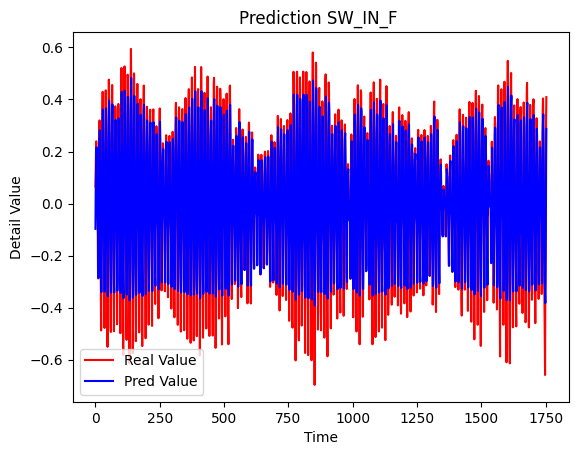

MSE: 0.019065742670665044
MAE: 0.1195637692905181
R²: 0.6966922519303905
RMSE: 0.13807875531979946


In [27]:
Result_Ana(best_model, 1)

## 3. Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [17]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.backend as K


# def Stack_LSTM():
#     model = Sequential()
#     model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
#     model.add(LSTM(100, activation='relu'))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model
def create_model(optimizer='adam', batch_size=32, epochs=40):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 6)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Stack_LSTM_Model = KerasRegressor(build_fn=create_model(), epochs=40, verbose=1, validation_data=(testX, testY))
Stack_LSTM_Model = KerasRegressor(create_model,verbose=1)
# history = Stack_LSTM().fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))

# Stack_LSTM_Model = KerasRegressor(Stack_LSTM,epochs=30,verbose=1, validation_data=(testX, testY))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_35732\4008304438.py:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Stack_LSTM_Model = KerasRegressor(create_model,verbose=1)


In [18]:
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'optimizer': ['adam'],
    'batch_size': [5,10,16, 32, 64],
    'epochs': [20,30, 40, 50]
}
# 执行网格搜索
grid = GridSearchCV(estimator=Stack_LSTM_Model, param_grid=param_grid, cv=2)
grid_result = grid.fit(trainX, trainY)

Epoch 1/20
702/702 [==============================] - 2s 1ms/step - loss: 0.0143
Epoch 2/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 3/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 4/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0046
Epoch 5/20
702/702 [==============================] - 1s 971us/step - loss: 0.0045
Epoch 6/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 7/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 8/20
702/702 [==============================] - 1s 980us/step - loss: 0.0046
Epoch 9/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0045
Epoch 10/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 11/20
702/702 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 12/20
702/702 [==============================] - 1s 981us/step - loss: 0.0044
Epoch 13/20
702/702

In [112]:
# 假设已经完成超参数优化并获得了最佳模型
best_model = grid_result.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(testX)


351/351 [==============================] - 0s 800us/step


In [26]:
%%time
Stack_LSTM_Model.fit(trainX, trainY)

Epoch 1/40
220/220 [==============================] - 3s 3ms/step - loss: 0.0375 - val_loss: 0.0059
Epoch 2/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 3/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 4/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 5/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 6/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 7/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 8/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 9/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 10/40
220/220 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0056

In [43]:
original_copies_array = np.repeat(testY, 6, axis=-1)
y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 6)))[-300:, 5]
y_true

array([ 0.236,  0.274,  0.28 ,  0.251,  0.159,  0.069,  0.009, -0.036,
       -0.012,  0.04 ,  0.17 ,  0.32 ,  0.464,  0.641,  0.743,  0.802,
        0.771,  0.647,  0.494,  0.342,  0.228,  0.152,  0.105,  0.111,
        0.139,  0.198,  0.235,  0.242,  0.177,  0.11 ,  0.029, -0.052,
       -0.083, -0.049,  0.034,  0.158,  0.357,  0.543,  0.681,  0.803,
        0.837,  0.767,  0.618,  0.455,  0.305,  0.15 ,  0.098,  0.057,
        0.056,  0.08 ,  0.145,  0.189,  0.209,  0.147,  0.058, -0.006,
       -0.04 , -0.063, -0.018,  0.077,  0.262,  0.445,  0.616,  0.726,
        0.817,  0.822,  0.753,  0.602,  0.423,  0.253,  0.135,  0.067,
        0.028,  0.029,  0.07 ,  0.144,  0.213,  0.229,  0.158,  0.078,
        0.017, -0.015, -0.017,  0.037,  0.154,  0.324,  0.499,  0.682,
        0.774,  0.853,  0.855,  0.767,  0.605,  0.429,  0.278,  0.16 ,
        0.1  ,  0.086,  0.11 ,  0.135,  0.187,  0.202,  0.167,  0.131,
        0.096,  0.034, -0.006, -0.003,  0.071,  0.192,  0.35 ,  0.501,
      

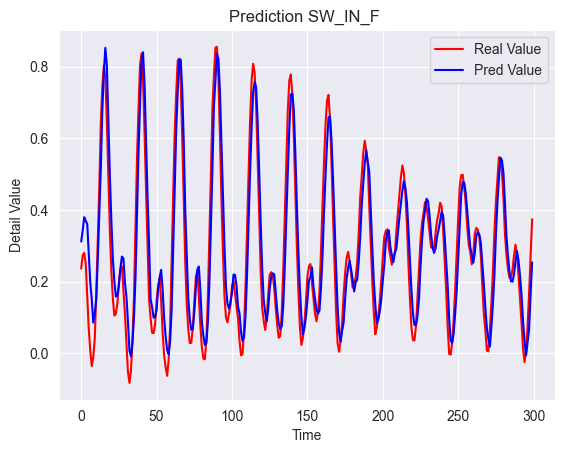

MSE: 0.0067089127084201195
MAE: 0.06759614620472615
R²: 0.8631584597522174
RMSE: 0.08190795265674829


In [20]:

y_pred = np.array(y_pred).reshape(-1, 1)
y_pred
y_pred.shape
prediction_copies_array = np.repeat(y_pred, 6,axis=-1)  #将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中

pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), 6)))[:,5]  #进行逆变换但是，只需要最后一列

# print(pred)
original_copies_array = np.repeat(testY, 6, axis=-1)
y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 6)))[:, 5]
y_true = y_true[-300:]
# print('y_true2:',y_true)
pred = pred[-300:]
# y_true = y_true[len(y_true)-test_len:len(y_true)-test_len+300]
# pred = pred[len(pred)-test_len:len(pred)-test_len+300]
plt.plot(y_true, color='red', label='Real Value')
plt.plot(pred, color='blue', label='Pred Value')
plt.title('Prediction SW_IN_F ')
plt.xlabel('Time')
plt.ylabel('Detail Value')
plt.legend()
# plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
print('MSE:',mse(y_true,pred))
print('MAE:',mae(y_true,pred))
print('R²:',r2(y_true,pred))
print('RMSE:',np.sqrt(mse(y_true,pred)))


260/260 [==============================] - 0s 730us/step


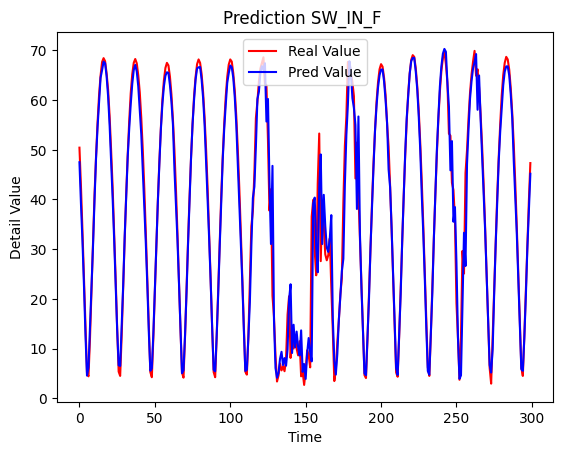

MSE: 20.231533142091948
MAE: 2.447641104917146
R²: 0.958271550878135
RMSE: 4.497947658887545


In [251]:
Result_Ana(Stack_LSTM_Model, 14)

## 4. Bidirectional LSTM


On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.

In [243]:
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import keras.backend as K


def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(1, 14)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# BiLSTM_Model = BiLSTM()
# history = BiLSTM_Model.fit(trainX,trainY,epochs=30,verbose=1,validation_data=(testX, testY))
BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
# Access the training and validation loss values
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# Print the training and validation loss values for each epoch
# for epoch in range(len(train_loss)):
#     print("Epoch {}: Train Loss = {}, Val Loss = {}".format(epoch+1, train_loss[epoch], val_loss[epoch]))

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_429876\2549510797.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


In [244]:
%%time
BiLSTM_Model.fit(trainX, trainY)

Epoch 1/40
1039/1039 [==============================] - 4s 2ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 2/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 3/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 4/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 5/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 6/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 7/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 8/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 9/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 10/40
1039/1039 [==============================] - 2s 2ms/step - loss: 0.006

260/260 [==============================] - 0s 694us/step


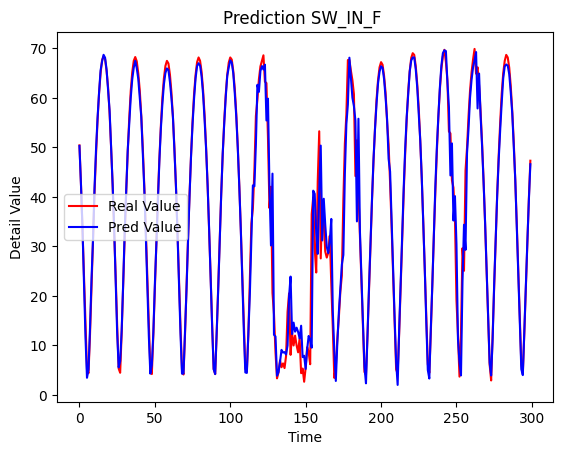

MSE: 18.903129224585264
MAE: 2.2113973837228937
R²: 0.9610114438410482
RMSE: 4.347772903980297


In [245]:
Result_Ana(BiLSTM_Model, 14)

## 5. CNN LSTM 

A convolutional neural network, or CNN for short, is a type of neural network developed for working with two-dimensional image data.

The CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data such as univariate time series data.

In [ ]:
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 1
# n_steps = 2
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [11]:
# Reshape trainX and testX to (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


In [ ]:
trainX.shape

In [ ]:
testX.shape

In [ ]:
trainX.shape

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

# Reshape trainX and testX to (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))


# Define model
def CnnLSTM():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# Train the model
CnnLSTM_Model = CnnLSTM().fit(trainX, trainY, epochs=30, verbose=1, validation_data=(testX, testY))

Epoch 1/30
784/784 [==============================] - 4s 4ms/step - loss: 0.0158 - val_loss: 0.0106
Epoch 2/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 3/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 4/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 5/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 6/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 7/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 8/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 9/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 10/30
784/784 [==============================] - 3s 3ms/step - loss: 0.0096 - val_loss: 0.0096

196/196 [==============================] - 0s 2ms/step


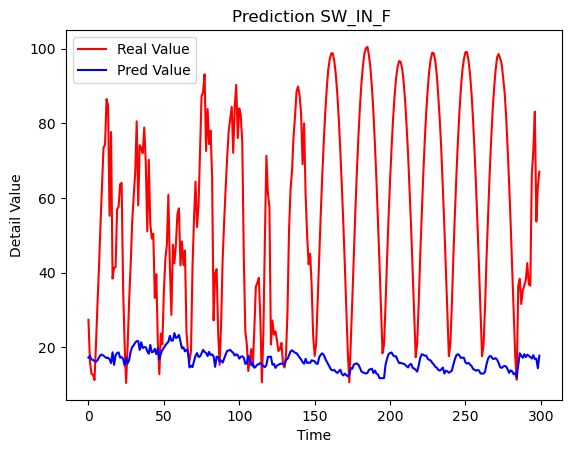

MSE: 2313.696828008055
MAE: 40.405593499144295
R²: -2.2840915325750046
RMSE: 48.1009025695782


In [15]:
Result_Ana(CnnLSTM(), 14)

In [ ]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


# define model
def CnnLSTM():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


CnnLSTM_Model = CnnLSTM().fit(trainX, trainY, epochs=30, verbose=1, validation_data=(testX, testY))

In [ ]:
# demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [ ]:
X

In [ ]:
X.shape

## 6. ConvLSTM

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

In [ ]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Multivariate LSTM Models

Multivariate time series data means data where there is more than one observation for each time step.



In [ ]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ##  Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting

In [ ]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Encoder-Decoder LSTM


In [ ]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

* ## Multivariate Multi-Step LSTM Models


In [ ]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Reference:-  https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecastings/